In [14]:
# Check Python Version (Itsuki is using anaconda3)
import sys
import platform

print(sys.version)
print(platform.architecture()[0]) # Check whether 32 or 64bit

3.9.12 (v3.9.12:b28265d7e6, Mar 23 2022, 18:22:40) 
[Clang 13.0.0 (clang-1300.0.29.30)]
64bit


# Analysis Roadmap (逐次更新)
## Preconditions
- No mice in ocean
  - 海岸線の緯度と経度を得て，海岸線より海側のネズミ発生確率を0に
## Method
- Related Indicators
  - Temperature
  - Population density (mesh data?)
  - Altitude（∝1/temperature?）
  - Species（各ネズミの大まかな生息条件を調べられるとbetter）
  - Family Tree
- 簡単のために，X軸: 経度，Y軸: 緯度の2次元平面上で表現→この平面上に海岸線を描画できる？
- 数kmメッシュに区切って，各メッシュのネズミ発生確率を予測する
  - ただし，学習データ上でネズミの発生確率が0となる: limitation
  - もちろん海上のメッシュは発生確率0
  - 図を見る限り緯度経度0.2度メッシュくらいが現実的に解析可能そうなライン？

# Key Takeaways (逐次更新)
- .shpなど地理データをGeoDataFrameにする時は正しいCRS (Coordinate Reference System; 例えば[EPSG:3035](https://epsg.io/3035))の指定が肝要
- Anacondaでは，仮想環境にpipするのがbetter: conda installは使わない！!
- [主観]質の高い地理データはEUとUSに多い印象
- [主観]降水量などの時系列データは.nc (NetCDF)が多い

In [2]:
import pandas as pd
import sqlite3

In [3]:
# Start Connection with SQLite
file_sqlite3 = "data/OpenMICE-August_2018/OpenMICE.sqlite"
conn = sqlite3.connect(file_sqlite3)
df_mice=pd.read_sql_query('SELECT * FROM data LEFT JOIN sites_information on data.sites_information_id = sites_information.id LEFT JOIN coordinates ON sites_information.coordinates_id = coordinates.id LEFT JOIN species_information ON data.species_information_id = species_information.id', conn)
conn.close()

In [4]:
df_mice = df_mice.drop('id', axis=1)
df_mice["id"] = df_mice.index + 1
print(df_mice.head())
df_mice.to_csv('data/mice.csv', index=True)

   inserted_by_id  species_information_id  sites_information_id event_date  \
0               1                       9                    13   26/06/16   
1               1                      22                    29   06/09/16   
2               1                      11                    29   06/09/16   
3               1                       3                    29   06/09/16   
4               1                      24                    29   06/09/16   

   predators_information_id identified_by_id references_id dataset_name_id  \
0                         4               33            44               2   
1                         5               33            44               2   
2                         5               33            44               2   
3                         5               33            44               2   
4                         5               33            44               2   

   institution_id  rigths_holder_id  ...  references_id_26  \


In [5]:
df_mice = pd.read_csv("data/mice.csv",index_col=False)

In [6]:
df_mice.columns

Index(['Unnamed: 0', 'inserted_by_id', 'species_information_id',
       'sites_information_id', 'event_date', 'predators_information_id',
       'identified_by_id', 'references_id', 'dataset_name_id',
       'institution_id', 'rigths_holder_id', 'recorded_by_id',
       'individual_count', 'occurrence_code', 'coordinates_id', 'locality',
       'verbatim_locality', 'municipality', 'province', 'region',
       'georeferenced_by_id', 'georeferenced_sources_id',
       'coordinate_precision_id', 'elevation_in_meters', 'latitude',
       'longitude', 'geometry', 'class', 'order', 'family', 'genus', 'species',
       'scientific_name', 'accepted_name_usage', 'common_name',
       'references_id_1', 'iucn_national_status', 'references_id_2',
       'habitat_directive', 'references_id_3', 'trophic_level_id',
       'references_id_4', 'prevalent_habit_id', 'references_id_5',
       'activity_pattern_id', 'references_id_6', 'guild_id', 'references_id_7',
       'habitat_preference_id', 'referen

In [7]:
# Choose only usable data (drop unnecessary data like id)
df_mice = df_mice[["id","event_date","latitude","longitude","scientific_name"]]

In [8]:
df_mice.head()

id event_date  latitude  longitude      scientific_name
0   1   26/06/16  41.42149   14.49559            Glis glis
1   2   06/09/16  41.58721   14.18007      Sorex antinorii
2   3   06/09/16  41.58721   14.18007       Microtus savii
3   4   06/09/16  41.58721   14.18007  Apodemus sylvaticus
4   5   06/09/16  41.58721   14.18007     Sorex samniticus

In [9]:
print(f'length of df_mice: {len(df_mice)}')

length of df_mice: 1999


In [10]:
df_mice[["scientific_name"]].value_counts()

scientific_name         
Microtus savii              260
Apodemus sp.                205
Suncus etruscus             177
Crocidura leucodon          170
Crocidura suaveolens        168
Mus domesticus              164
Muscardinus avellanarius    128
Rattus rattus               110
Apodemus sylvaticus          94
Myodes glareolus             93
Sorex sp.                    81
Sorex samniticus             71
Crocidura sp.                44
Sorex minutus                36
Rattus sp.                   34
Apodemus flavicollis         32
Talpa romana                 18
Arvicola italicus            16
Neomys milleri               13
Sorex antinorii              12
Rattus norvegicus            11
Eliomys quercinus            10
Neomys sp.                   10
Glis glis                     8
Neomys fodiens                7
Microtus multiplex            4
Talpa sp.                     4
Talpa caeca                   3
Sciurus vulgaris              1
Name: count, dtype: int64

In [11]:
# Check NA
df_mice.isna().sum()

id                  0
event_date          0
latitude            0
longitude           0
scientific_name    15
dtype: int64

→欠損値多め．かなぴ

# Data Visualisation

## Geo - Map

In [12]:
# It is not recommended to use pip to install geopandas: https://geopandas.org/en/stable/getting_started/install.html
# Better to use Conda instead of pip
# %conda install geopandas

In [13]:
import geopandas as gpd

ModuleNotFoundError: No module named 'geopandas'

In [14]:
gdf_mice = gpd.GeoDataFrame(df_mice, 
            geometry=gpd.points_from_xy(df_mice.longitude, df_mice.latitude),
            crs="EPSG:4326" # This line is really important to make coordinate machine readable
)
gdf_mice.drop(columns=['longitude', 'latitude'])

id  event_date           scientific_name                   geometry
0        1    26/06/16                 Glis glis  POINT (14.49559 41.42149)
1        2    06/09/16           Sorex antinorii  POINT (14.18007 41.58721)
2        3    06/09/16            Microtus savii  POINT (14.18007 41.58721)
3        4    06/09/16       Apodemus sylvaticus  POINT (14.18007 41.58721)
4        5    06/09/16          Sorex samniticus  POINT (14.18007 41.58721)
...    ...         ...                       ...                        ...
1994  1995  00/00/1996      Crocidura suaveolens  POINT (12.41809 41.77606)
1995  1996  00/00/1996  Muscardinus avellanarius  POINT (12.41809 41.77606)
1996  1997  00/00/1996            Microtus savii  POINT (12.41809 41.77606)
1997  1998  00/00/1996              Apodemus sp.  POINT (12.41809 41.77606)
1998  1999  00/00/1996            Mus domesticus  POINT (12.41809 41.77606)

[1999 rows x 4 columns]

In [15]:
# import folium

# # # Create a map centered around the mean latitude and longitude
# m = folium.Map(location=[gdf_mice['latitude'].mean(), gdf_mice['longitude'].mean()])

# # # Add the GeoDataFrame to the map as markers
# for idx, row in gdf_mice.iterrows():
#     folium.Marker(location=[row['latitude'], row['longitude']], popup=row['scientific_name']).add_to(m)

# # # Display the map
# m

## Geo - XY-coordinate

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='longitude', ylabel='latitude'>

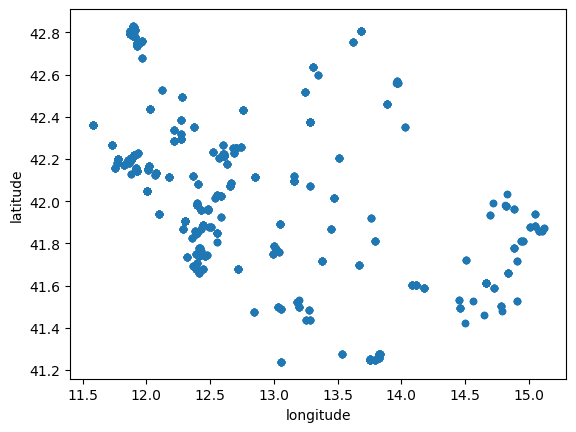

In [17]:
# 2次元平面上に可視化
df_mice.plot.scatter(x="longitude",y="latitude")

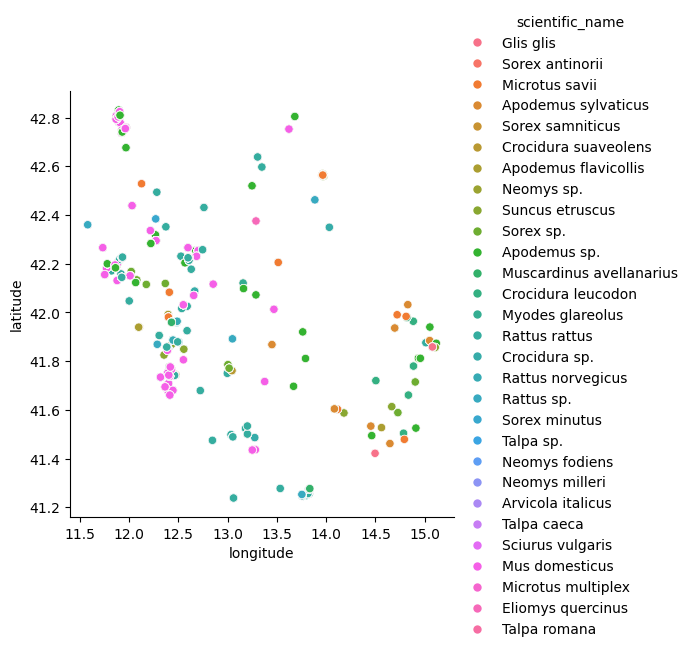

In [18]:
# マウスの種類別に可視化
sns.relplot(data=df_mice, x="longitude", y="latitude", hue="scientific_name")
plt.show()

→種類が多すぎるので，とりあえずscientific_nameは無視でもいいかも

## Latitude and Longitude

In [19]:
print(f'latitude_max: {df_mice["latitude"].max()}')
print(f'latitude_min: {df_mice["latitude"].min()}')
print(f'longitude_max: {df_mice["longitude"].max()}')
print(f'longitude_min: {df_mice["longitude"].min()}')

latitude_max: 42.83102
latitude_min: 41.23798
longitude_max: 15.11688
longitude_min: 11.58002


→latitudeとlongitudeの変域
- latitude = [41,42]
- longitude = [11,16]

# Prediction

- 使えそうなデータ
  - ネズミの親子関係（from OpenMICE）
  - 

# Data Analysis

## Gridding of point data with geopandas
Refer to: https://james-brennan.github.io/posts/fast_gridding_geopandas/


In [20]:
gdf_mice.head()

id event_date  latitude  longitude      scientific_name  \
0   1   26/06/16  41.42149   14.49559            Glis glis   
1   2   06/09/16  41.58721   14.18007      Sorex antinorii   
2   3   06/09/16  41.58721   14.18007       Microtus savii   
3   4   06/09/16  41.58721   14.18007  Apodemus sylvaticus   
4   5   06/09/16  41.58721   14.18007     Sorex samniticus   

                    geometry  
0  POINT (14.49559 41.42149)  
1  POINT (14.18007 41.58721)  
2  POINT (14.18007 41.58721)  
3  POINT (14.18007 41.58721)  
4  POINT (14.18007 41.58721)

In [21]:
world_path = "data/COAS_RG_20M_2016_3035/COAS_RG_20M_2016_3035.shp"
gdf_world = gpd.read_file(world_path, crs="EPSG:3035")
gdf_world.head()

COAS_ID  FID                                           geometry
0        1    1  POLYGON ((11851260.434 6576391.596, 11868666.6...
1        2    2  POLYGON ((-1609517.181 -6509412.671, -1562130....
2        3    3  POLYGON ((2486296.605 7635743.437, 2476586.837...
3        4    4  POLYGON ((14351721.391 8624477.394, 14394710.5...
4        6    6  POLYGON ((3513167.258 7276604.460, 3488015.963...

<Axes: >

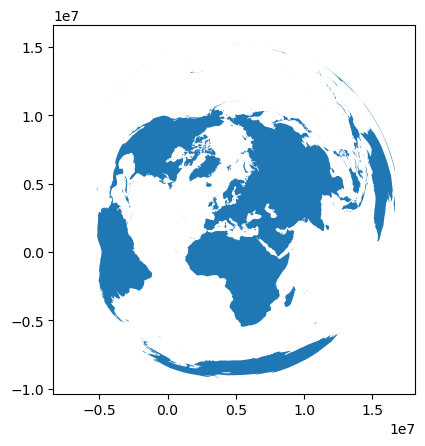

In [22]:
gdf_world.plot()

<Axes: >

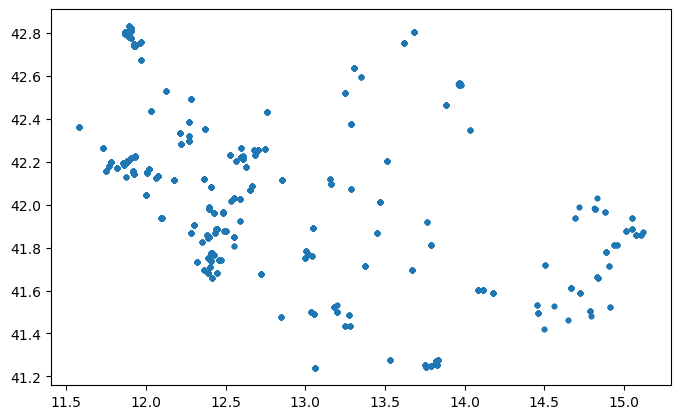

In [23]:
gdf_mice.plot(markersize=10, figsize=(8, 8))

In [24]:
ax = gdf_mice.plot(markersize=10, figsize=(12, 8), column='scientific_name', cmap='jet')
plt.autoscale(False)
gdf_world.to_crs(gdf_mice.crs).plot(ax=ax, color='none', edgecolor='lightgrey')

<Axes: >

In [25]:
import numpy as np
import shapely
np.random.seed(42) # Don't panic!

## Example of Creating Grid

In [26]:
# total area for the grid
xmin, ymin, xmax, ymax= gdf_mice.total_bounds
# how many cells across and down
# In this case, cell size is 1/30*(max_latitude - min_latitude)
n_cells=30
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "EPSG:4326"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

(11.403177, 15.293723, 41.158328, 42.910672000000005)

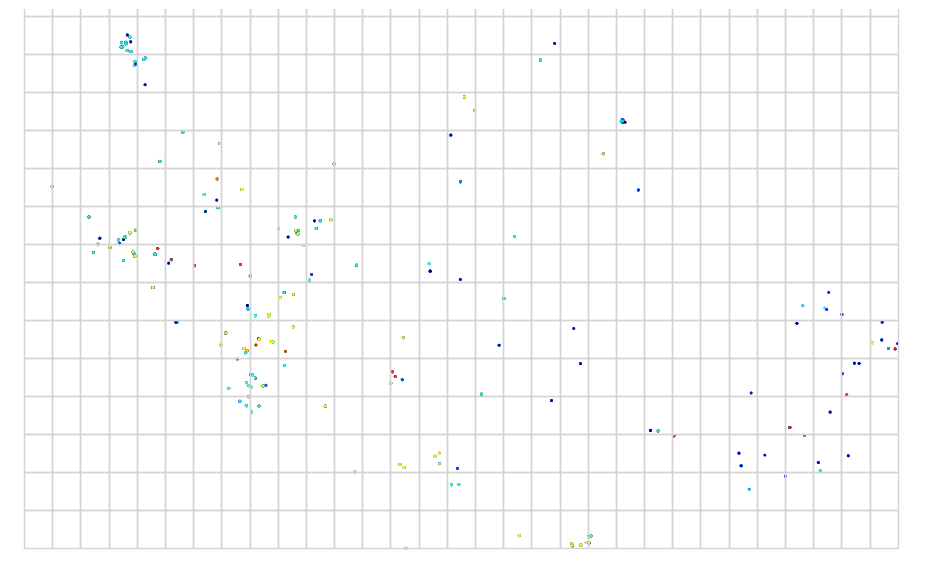

In [27]:
ax = gdf_mice.plot(markersize=1, figsize=(12, 8), column='scientific_name', cmap='jet')
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='lightgrey')
ax.axis("off")

In [28]:
gdf_mice_merged = gpd.sjoin(gdf_mice, cell, how='left', predicate='within')

In [29]:
gdf_mice_merged.head()

id event_date  latitude  longitude      scientific_name  \
0   1   26/06/16  41.42149   14.49559            Glis glis   
1   2   06/09/16  41.58721   14.18007      Sorex antinorii   
2   3   06/09/16  41.58721   14.18007       Microtus savii   
3   4   06/09/16  41.58721   14.18007  Apodemus sylvaticus   
4   5   06/09/16  41.58721   14.18007     Sorex samniticus   

                    geometry  index_right  
0  POINT (14.49559 41.42149)        376.0  
1  POINT (14.18007 41.58721)        347.0  
2  POINT (14.18007 41.58721)        347.0  
3  POINT (14.18007 41.58721)        347.0  
4  POINT (14.18007 41.58721)        347.0

In [30]:
# make a simple count variable that we can sum
gdf_mice_merged['mice_occurrence']=1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = gdf_mice_merged.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'mice_occurrence'] = dissolve.mice_occurrence.values

In [31]:
cell.head()

geometry  mice_occurrence
0  POLYGON ((11.46212 41.23798, 11.46212 41.35588...              NaN
1  POLYGON ((11.46212 41.35588, 11.46212 41.47377...              NaN
2  POLYGON ((11.46212 41.47377, 11.46212 41.59167...              NaN
3  POLYGON ((11.46212 41.59167, 11.46212 41.70956...              NaN
4  POLYGON ((11.46212 41.70956, 11.46212 41.82746...              NaN

In [32]:
cell["mice_occurrence"].max()

122.0

In [33]:
cell["mice_occurrence"].plot(kind='bar')


<Axes: >

(11.5269671, 15.287828233333329, 41.15545326666666, 42.971041400000054)

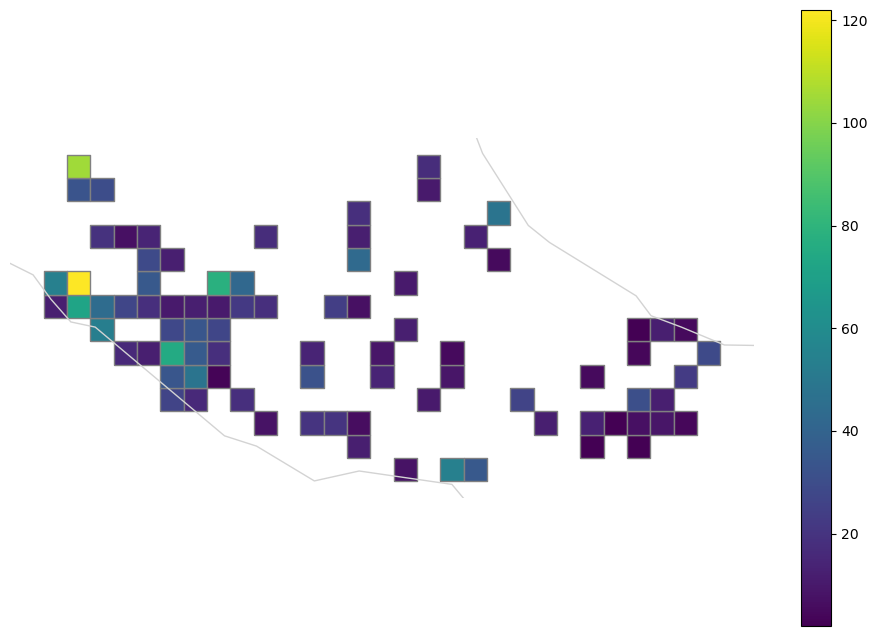

In [34]:
ax = cell.plot(column='mice_occurrence', figsize=(12, 8), cmap='viridis', vmax=122, edgecolor="grey", legend=True)
plt.autoscale(False)
plt.colormaps()
gdf_world.to_crs(cell.crs).plot(ax=ax, color='none', edgecolor='lightgrey')
ax.axis('off')

## Flow of Analysis (tentative)
1. gridにid付ける
2. gdf_mice内にgrid_idを入れる
3. grid_idごとにねずみの発生しやすさを求める(should define "発生しやすさ")
4. →gridごとの気温と人口密度（+ねずみの発生を予測しそうな外的要因）を持ってきて，それらの変数からmiceの発生しやすさをモデル化する

miceの発生しやすさ: "likelihood of mice occurrence" (以下"lhmo")
- gridの"lhmo"が大きいほどmiceの報告数が多くなるようにしたい
- 目標: mice_occurrence > 0を元データにして，mice_occurrence = 0のgrid内でのmice_occurrenceの数を予測する
  - holdoutなら，train_data: 80% of total grids (もちろんgrid[mice_occurrence] != 0), test_data: 20% of total gridsみたいな感じ
  - →これで精度を挙げて，grids whose mice_occurrence = 0のmice_occurrenceを予測する

- Problem: 気温や人口のデータがEU圏内，もしくはイタリアでどのような地区単位で収集されているのか知る必要がある．
  - [人口]1km四方のpolygon population dataが存在: https://ec.europa.eu/eurostat/web/gisco/geodata/grids
  - [平均気温]
  - [平均標高]

In [35]:
# 人口密度メッシュ（5km四方）
gdf_grid_5km = gpd.read_file("data/grid/grid_5km_surf.gpkg")

In [36]:
gdf_grid_5km = gdf_grid_5km[gdf_grid_5km["CNTR_ID"] == "IT"]

In [37]:
gdf_grid_5km.head()

DIST_BORD  TOT_P_2018  TOT_P_2006                           GRD_ID  \
249   7329.919922        23.0         2.0  CRS3035RES5000mN2510000E4090000   
250  11601.150391       664.0       680.0  CRS3035RES5000mN2510000E4095000   
251  16286.799805      3167.0      3294.0  CRS3035RES5000mN2510000E4100000   
252  19567.919922      3069.0      2862.0  CRS3035RES5000mN2510000E4105000   
253  21305.480469       348.0       873.0  CRS3035RES5000mN2510000E4110000   

     TOT_P_2011  TOT_P_2021    Y_LLC CNTR_ID NUTS2016_3 NUTS2016_2 NUTS2016_1  \
249        25.0          24  2510000      IT      ITC20       ITC2        ITC   
250       671.0         797  2510000      IT      ITC20       ITC2        ITC   
251      3119.0        3034  2510000      IT      ITC20       ITC2        ITC   
252      3069.0        3110  2510000      IT      ITC20       ITC2        ITC   
253       334.0         384  2510000      IT      ITC20       ITC2        ITC   

    NUTS2016_0  LAND_PC    X_LLC NUTS2021_3 NUTS2021_2     DIST_COAST  \
249         IT    100.0  4090000      ITC20       ITC2  188582.968750   
250         IT    100.0  4095000      ITC20       ITC2  185743.750000   
251         IT    100.0  4100000      ITC20       ITC2  182995.031250   
252         IT    100.0  4105000      ITC20       ITC2  180339.656250   
253         IT    100.0  4110000      ITC20       ITC2  177785.296875   

    NUTS2021_1 NUTS2021_0                                           geometry  
249        ITC         IT  POLYGON ((4090000.000 2510000.000, 4095000.000...  
250        ITC         IT  POLYGON ((4095000.000 2510000.000, 4100000.000...  
251        ITC         IT  POLYGON ((4100000.000 2510000.000, 4105000.000...  
252        ITC         IT  POLYGON ((4105000.000 2510000.000, 4110000.000...  
253        ITC         IT  POLYGON ((4110000.000 2510000.000, 4115000.000...

Text(0.5, 1.0, 'Population Density')

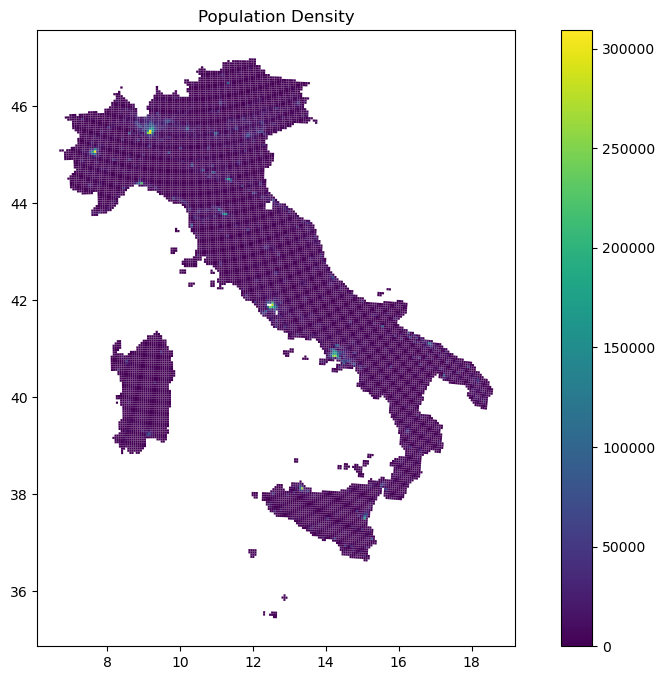

In [38]:
gdf_grid_5km.to_crs("EPSG:4326").plot(column="TOT_P_2021", figsize=(12,8), legend=True, edgecolor="none")
plt.title("Population Density")

In [39]:
import matplotlib.colors as colors

<Axes: title={'center': 'Mice Occurrence in South-Central Italy'}>

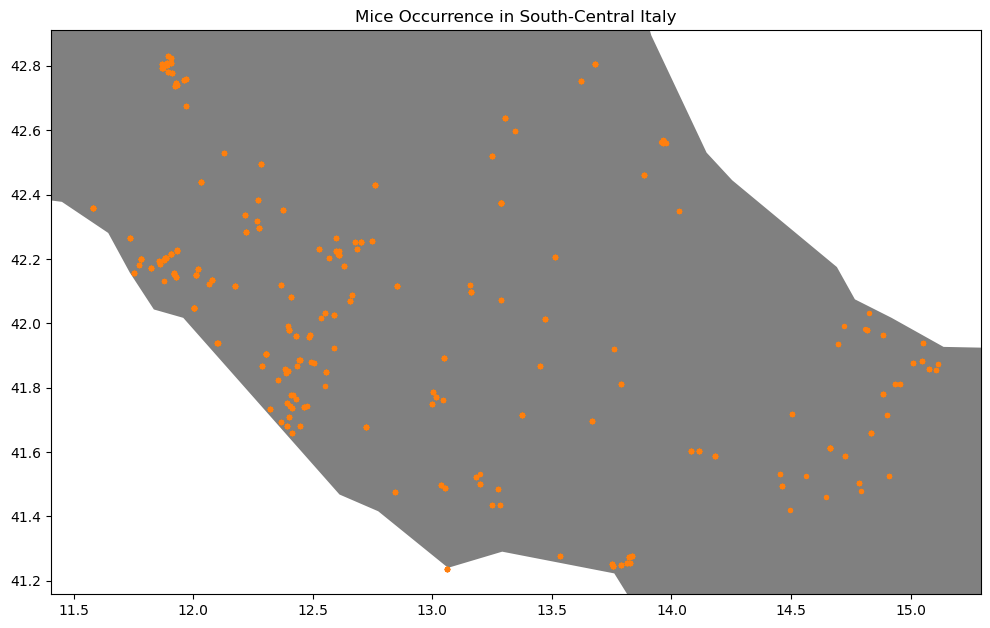

In [40]:

ax = gdf_mice.plot(figsize=(12, 8), markersize=0)
plt.title("Mice Occurrence in South-Central Italy")
plt.autoscale(False)
gdf_world.to_crs(gdf_mice.crs).plot(ax=ax, color="grey")
gdf_mice.plot(ax=ax, markersize=8)

In [41]:
def plot_gdfs(gdf_scatter, gdf_base, lognorm):
    title = ""
    if lognorm:
        norm = colors.LogNorm()
        title = "Population Density (LogNorm)"
    else:
        norm = None
        title = "Population Density"
    ax = gdf_scatter.plot(figsize=(12, 8), markersize=0)
    plt.title(title + " " + "and Mice Occurrence")
    plt.autoscale(False)
    gdf_base.to_crs(gdf_scatter.crs).plot(ax=ax, cmap="gray", column="TOT_P_2021", edgecolor='lightgrey', norm=norm, legend=True)
    gdf_scatter.plot(ax=ax, markersize=10)

In [42]:
plot_gdfs(gdf_mice,gdf_grid_5km,False)

In [43]:
# 人口密度が見えにくいのでLogarithmic Normalisationした
## Refer to: https://matplotlib.org/stable/users/explain/colors/colormapnorms.html

plot_gdfs(gdf_mice,gdf_grid_5km,True)

## Flow of Analysis (from now on)
- gdf_grid_5kmに["mice_occurrence", "temperature", "avg_altitude", "precipitation(降水量)","緑化率","耕作地率"]などを突っ込み，grid[mice_occurrence != 0]でモデル作成→モデルをgrid[mice_occurrence = 0]に当てはめてMice_occurrence mapを作成
  1. Gridの中心地点（Grid二対角線の交点）を求めて，gdf_grid_5km["ctr_co"] (="center coordinate")に挿入
  2. Temperature, avg_altitudeは，gridの中心地点（二対角線の交点）に最寄りの（latitude, longitudeの差の二乗和が最も小さい）データを取ってくる
  - Temperatureとavg_altitudeはある程度相関していそうなので，多重共線性（"Multicollinearity", "マルティコ"）に注意

## Think with Grid

In [44]:
gdf_mice.head()

id event_date  latitude  longitude      scientific_name  \
0   1   26/06/16  41.42149   14.49559            Glis glis   
1   2   06/09/16  41.58721   14.18007      Sorex antinorii   
2   3   06/09/16  41.58721   14.18007       Microtus savii   
3   4   06/09/16  41.58721   14.18007  Apodemus sylvaticus   
4   5   06/09/16  41.58721   14.18007     Sorex samniticus   

                    geometry  
0  POINT (14.49559 41.42149)  
1  POINT (14.18007 41.58721)  
2  POINT (14.18007 41.58721)  
3  POINT (14.18007 41.58721)  
4  POINT (14.18007 41.58721)

In [45]:
gdf_grid_5km.head()

DIST_BORD  TOT_P_2018  TOT_P_2006                           GRD_ID  \
249   7329.919922        23.0         2.0  CRS3035RES5000mN2510000E4090000   
250  11601.150391       664.0       680.0  CRS3035RES5000mN2510000E4095000   
251  16286.799805      3167.0      3294.0  CRS3035RES5000mN2510000E4100000   
252  19567.919922      3069.0      2862.0  CRS3035RES5000mN2510000E4105000   
253  21305.480469       348.0       873.0  CRS3035RES5000mN2510000E4110000   

     TOT_P_2011  TOT_P_2021    Y_LLC CNTR_ID NUTS2016_3 NUTS2016_2 NUTS2016_1  \
249        25.0          24  2510000      IT      ITC20       ITC2        ITC   
250       671.0         797  2510000      IT      ITC20       ITC2        ITC   
251      3119.0        3034  2510000      IT      ITC20       ITC2        ITC   
252      3069.0        3110  2510000      IT      ITC20       ITC2        ITC   
253       334.0         384  2510000      IT      ITC20       ITC2        ITC   

    NUTS2016_0  LAND_PC    X_LLC NUTS2021_3 NUTS2021_2     DIST_COAST  \
249         IT    100.0  4090000      ITC20       ITC2  188582.968750   
250         IT    100.0  4095000      ITC20       ITC2  185743.750000   
251         IT    100.0  4100000      ITC20       ITC2  182995.031250   
252         IT    100.0  4105000      ITC20       ITC2  180339.656250   
253         IT    100.0  4110000      ITC20       ITC2  177785.296875   

    NUTS2021_1 NUTS2021_0                                           geometry  
249        ITC         IT  POLYGON ((4090000.000 2510000.000, 4095000.000...  
250        ITC         IT  POLYGON ((4095000.000 2510000.000, 4100000.000...  
251        ITC         IT  POLYGON ((4100000.000 2510000.000, 4105000.000...  
252        ITC         IT  POLYGON ((4105000.000 2510000.000, 4110000.000...  
253        ITC         IT  POLYGON ((4110000.000 2510000.000, 4115000.000...

In [46]:
# Insert "mice_occurrence" (the number of mice observed in the grid) in gdf_grid_5km
gdf_grid_5km_merged = gdf_grid_5km.join(
    gpd.sjoin(gdf_mice.to_crs(gdf_grid_5km.crs), gdf_grid_5km).groupby("index_right").size().rename("mice_occurrence"),
    how="left",
)

In [47]:
gdf_grid_5km_merged.head()

DIST_BORD  TOT_P_2018  TOT_P_2006                           GRD_ID  \
249   7329.919922        23.0         2.0  CRS3035RES5000mN2510000E4090000   
250  11601.150391       664.0       680.0  CRS3035RES5000mN2510000E4095000   
251  16286.799805      3167.0      3294.0  CRS3035RES5000mN2510000E4100000   
252  19567.919922      3069.0      2862.0  CRS3035RES5000mN2510000E4105000   
253  21305.480469       348.0       873.0  CRS3035RES5000mN2510000E4110000   

     TOT_P_2011  TOT_P_2021    Y_LLC CNTR_ID NUTS2016_3 NUTS2016_2  ...  \
249        25.0          24  2510000      IT      ITC20       ITC2  ...   
250       671.0         797  2510000      IT      ITC20       ITC2  ...   
251      3119.0        3034  2510000      IT      ITC20       ITC2  ...   
252      3069.0        3110  2510000      IT      ITC20       ITC2  ...   
253       334.0         384  2510000      IT      ITC20       ITC2  ...   

    NUTS2016_0 LAND_PC    X_LLC  NUTS2021_3 NUTS2021_2     DIST_COAST  \
249         IT   100.0  4090000       ITC20       ITC2  188582.968750   
250         IT   100.0  4095000       ITC20       ITC2  185743.750000   
251         IT   100.0  4100000       ITC20       ITC2  182995.031250   
252         IT   100.0  4105000       ITC20       ITC2  180339.656250   
253         IT   100.0  4110000       ITC20       ITC2  177785.296875   

     NUTS2021_1 NUTS2021_0                                           geometry  \
249         ITC         IT  POLYGON ((4090000.000 2510000.000, 4095000.000...   
250         ITC         IT  POLYGON ((4095000.000 2510000.000, 4100000.000...   
251         ITC         IT  POLYGON ((4100000.000 2510000.000, 4105000.000...   
252         ITC         IT  POLYGON ((4105000.000 2510000.000, 4110000.000...   
253         ITC         IT  POLYGON ((4110000.000 2510000.000, 4115000.000...   

    mice_occurrence  
249             NaN  
250             NaN  
251             NaN  
252             NaN  
253             NaN  

[5 rows x 21 columns]

In [48]:
gdf_grid_5km_merged["mice_occurrence"].value_counts()

mice_occurrence
12.0    10
5.0      9
7.0      9
10.0     7
9.0      7
6.0      6
18.0     6
2.0      6
4.0      6
11.0     5
13.0     5
22.0     4
8.0      4
14.0     4
16.0     3
17.0     3
25.0     2
26.0     2
24.0     2
52.0     2
3.0      2
43.0     2
20.0     2
27.0     2
19.0     2
29.0     2
23.0     1
33.0     1
48.0     1
55.0     1
46.0     1
70.0     1
15.0     1
36.0     1
31.0     1
53.0     1
28.0     1
21.0     1
50.0     1
Name: count, dtype: int64

<Axes: title={'center': 'Population Density (LogNorm)'}>

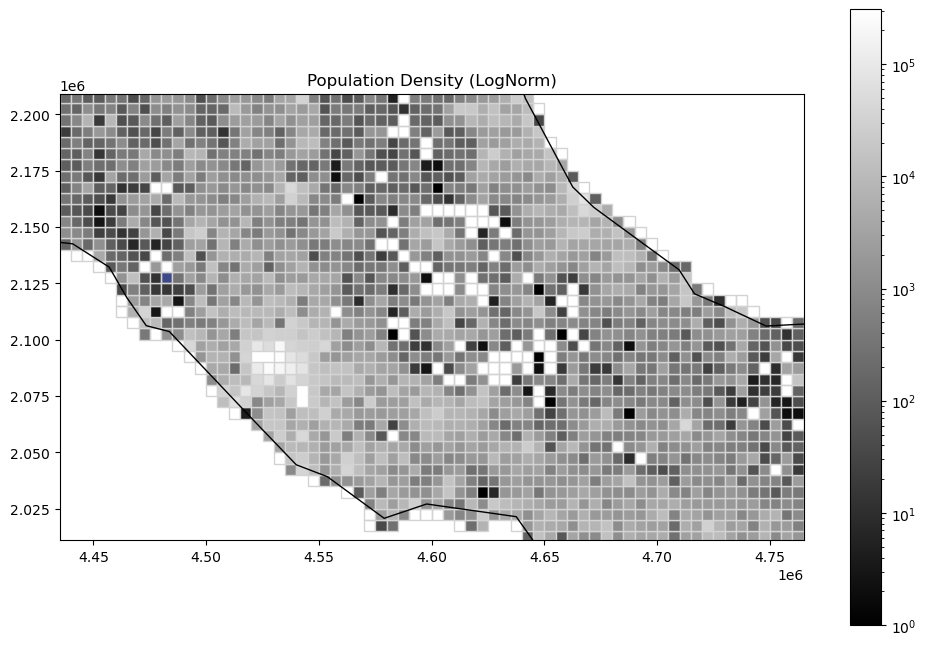

In [49]:
ax = gdf_grid_5km_merged.plot(column="mice_occurrence", figsize=(12, 8))
plt.title("Population Density (LogNorm)")
plt.autoscale(False)
gdf_grid_5km_merged.plot(ax=ax, cmap="gray", column="TOT_P_2021", edgecolor='lightgrey', norm=colors.LogNorm(), legend=True)
gdf_world.plot(ax=ax, color='none', edgecolor='black')

<Axes: title={'center': 'Mice Occurrence Density'}>

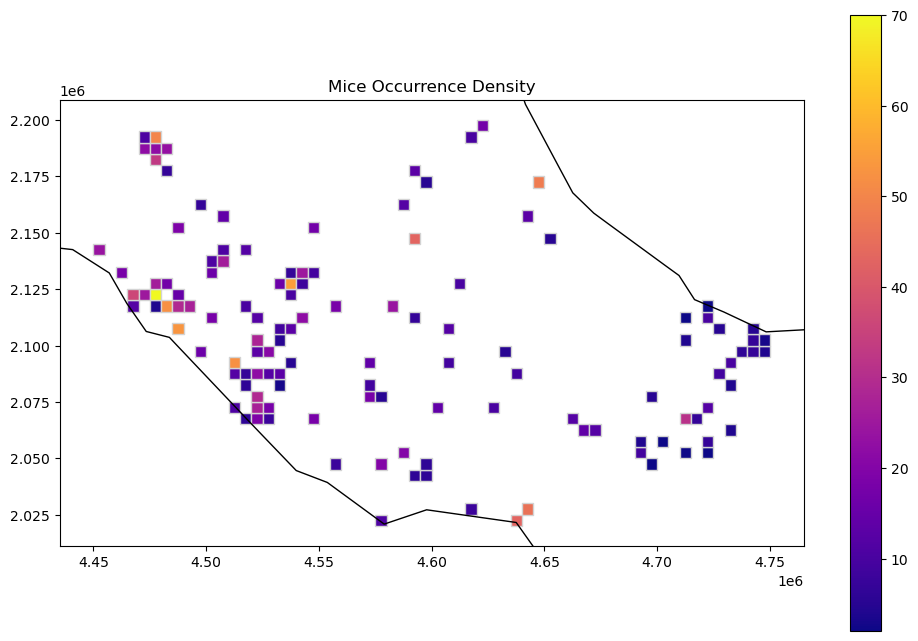

In [50]:
ax = gdf_grid_5km_merged.plot(column="mice_occurrence", figsize=(12, 8))
plt.title("Mice Occurrence Density")
plt.autoscale(False)
gdf_grid_5km_merged.plot(ax=ax, cmap="plasma", column="mice_occurrence", edgecolor='lightgrey', legend=True)
gdf_world.plot(ax=ax, color='none', edgecolor='black')

### UAA - Utilised agricultural area (Hectare)

In [51]:
gdf_agri_uaa = gpd.read_file("data/geospatial_data_from_agricultural_census/c17/c17.shp")

In [52]:
gdf_agri_uaa.head()

ID   res    area nuts2  HOLDING   SO_EURO    UAA  HldnPK2  UAAprHl  \
0   1  1000  0.7165  MT00      NaN       NaN    NaN      NaN      NaN   
1   2  1000  1.0000  MT00     60.0  348000.0   70.0     60.0     1.20   
2   3  1000  1.0000  MT00    110.0  350000.0  100.0    110.0     0.91   
3   4  1000  1.0000  MT00     20.0  317000.0   30.0     20.0     1.50   
4   5  1000  1.0000  MT00      NaN       NaN    NaN      NaN      NaN   

   SOprHld                                           geometry  
0      NaN  POLYGON ((4715000.000 1450000.000, 4715000.000...  
1   5800.0  POLYGON ((4717000.000 1444000.000, 4717000.000...  
2   3200.0  POLYGON ((4718000.000 1444000.000, 4718000.000...  
3  16000.0  POLYGON ((4719000.000 1444000.000, 4719000.000...  
4      NaN  POLYGON ((4717000.000 1443000.000, 4717000.000...

<Axes: >

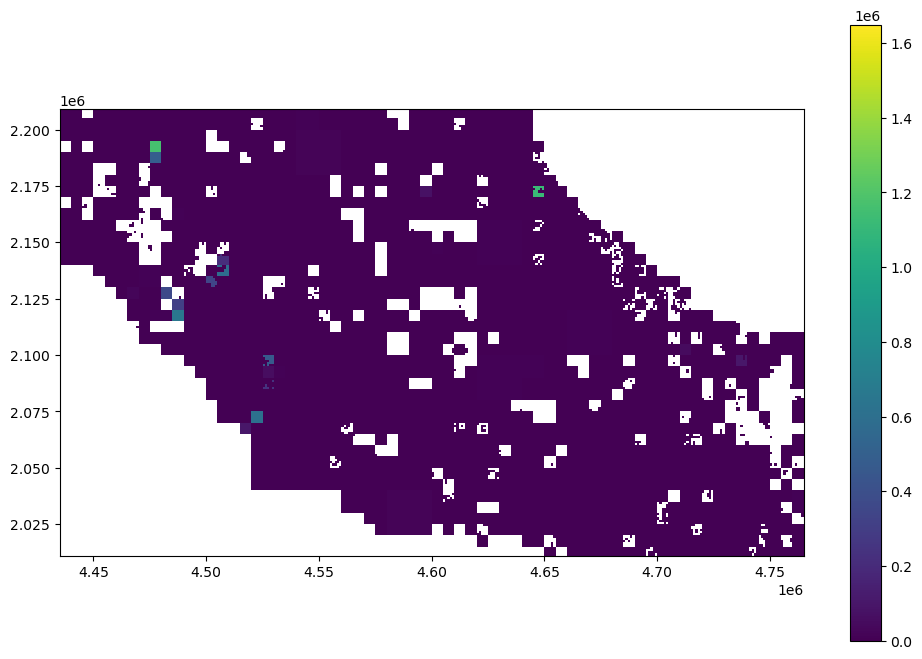

In [53]:
ax = gdf_grid_5km_merged.plot(column="mice_occurrence", figsize=(12, 8))
plt.autoscale(False)
gdf_agri_uaa.plot(ax=ax,column="UAA", legend=True)

<Axes: >

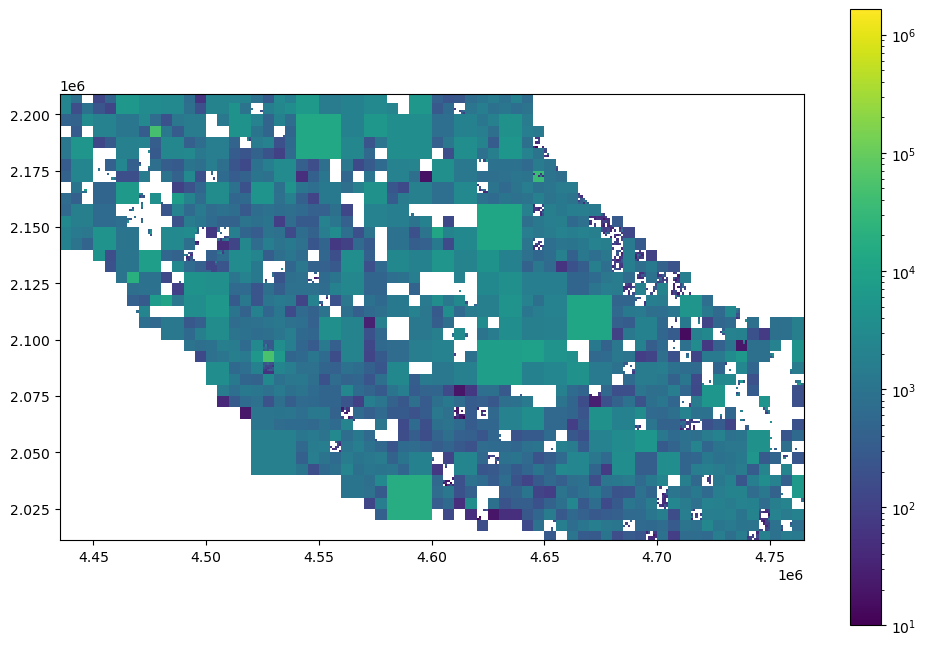

In [54]:
ax = gdf_grid_5km_merged.plot(column="mice_occurrence", figsize=(12, 8))
plt.autoscale(False)
gdf_agri_uaa.plot(ax=ax,column="UAA", legend=True, norm=colors.LogNorm())

In [55]:
gdf_grid_5km_uaa = gdf_grid_5km_merged.sjoin(gdf_agri_uaa.to_crs(gdf_grid_5km_merged.crs)[["geometry", "UAA"]], how="inner", predicate='intersects').to_crs("EPSG:4326")

In [56]:
gdf_grid_5km_merged["geometry"]

249       POLYGON ((4090000.000 2510000.000, 4095000.000...
250       POLYGON ((4095000.000 2510000.000, 4100000.000...
251       POLYGON ((4100000.000 2510000.000, 4105000.000...
252       POLYGON ((4105000.000 2510000.000, 4110000.000...
253       POLYGON ((4110000.000 2510000.000, 4115000.000...
                                ...                        
290176    POLYGON ((4540000.000 2505000.000, 4545000.000...
290178    POLYGON ((4545000.000 2505000.000, 4550000.000...
290179    POLYGON ((4550000.000 2505000.000, 4555000.000...
290180    POLYGON ((4555000.000 2505000.000, 4560000.000...
290181    POLYGON ((4560000.000 2505000.000, 4565000.000...
Name: geometry, Length: 12941, dtype: geometry

In [57]:
gdf_agri_uaa.to_crs(gdf_grid_5km_merged.crs)["geometry"]

0         POLYGON ((4715000.000 1450000.000, 4715000.000...
1         POLYGON ((4717000.000 1444000.000, 4717000.000...
2         POLYGON ((4718000.000 1444000.000, 4718000.000...
3         POLYGON ((4719000.000 1444000.000, 4719000.000...
4         POLYGON ((4717000.000 1443000.000, 4717000.000...
                                ...                        
129810    POLYGON ((5400000.000 1560000.000, 5400000.000...
129811    POLYGON ((5560000.000 1480000.000, 5560000.000...
129812    POLYGON ((1960000.000 1000000.000, 1960000.000...
129813    POLYGON ((1760000.000 960000.000, 1760000.000 ...
129814    POLYGON ((1920000.000 960000.000, 1920000.000 ...
Name: geometry, Length: 129815, dtype: geometry

In [58]:
gdf_grid_5km_uaa["UAA"].value_counts()

UAA
50.0       647
70.0       644
110.0      638
90.0       637
60.0       624
          ... 
5350.0       1
7770.0       1
6610.0       1
15600.0      1
5520.0       1
Name: count, Length: 683, dtype: int64

In [59]:
gdf_grid_5km_uaa["mice_occurrence"].value_counts()

mice_occurrence
12.0    98
7.0     75
5.0     72
6.0     54
13.0    53
10.0    53
9.0     49
11.0    48
18.0    44
2.0     41
22.0    40
4.0     39
16.0    37
8.0     37
14.0    33
48.0    29
21.0    27
26.0    21
17.0    20
20.0    17
3.0     15
43.0    15
29.0    13
25.0    13
19.0    12
52.0    12
31.0    12
27.0    10
24.0    10
28.0     9
46.0     9
33.0     8
55.0     8
50.0     8
36.0     7
23.0     5
15.0     4
53.0     4
70.0     4
Name: count, dtype: int64

In [60]:
gdf_grid_5km_uaa.plot(column="UAA", norm=colors.LogNorm(), figsize=(12,8), legend=True)
plt.title("UAA")

Text(0.5, 1.0, 'UAA')

In [61]:
gdf_grid_5km_uaa

DIST_BORD  TOT_P_2018  TOT_P_2006                           GRD_ID  \
249      7329.919922        23.0         2.0  CRS3035RES5000mN2510000E4090000   
250     11601.150391       664.0       680.0  CRS3035RES5000mN2510000E4095000   
250     11601.150391       664.0       680.0  CRS3035RES5000mN2510000E4095000   
250     11601.150391       664.0       680.0  CRS3035RES5000mN2510000E4095000   
250     11601.150391       664.0       680.0  CRS3035RES5000mN2510000E4095000   
...              ...         ...         ...                              ...   
290181  43628.628906       412.0      1240.0  CRS3035RES5000mN2505000E4560000   
290181  43628.628906       412.0      1240.0  CRS3035RES5000mN2505000E4560000   
290181  43628.628906       412.0      1240.0  CRS3035RES5000mN2505000E4560000   
290181  43628.628906       412.0      1240.0  CRS3035RES5000mN2505000E4560000   
290181  43628.628906       412.0      1240.0  CRS3035RES5000mN2505000E4560000   

        TOT_P_2011  TOT_P_2021    Y_LLC CNTR_ID   NUTS2016_3 NUTS2016_2  ...  \
249           25.0          24  2510000      IT        ITC20       ITC2  ...   
250          671.0         797  2510000      IT        ITC20       ITC2  ...   
250          671.0         797  2510000      IT        ITC20       ITC2  ...   
250          671.0         797  2510000      IT        ITC20       ITC2  ...   
250          671.0         797  2510000      IT        ITC20       ITC2  ...   
...            ...         ...      ...     ...          ...        ...  ...   
290181       395.0         503  2505000      IT  ITH35-ITH42  ITH3-ITH4  ...   
290181       395.0         503  2505000      IT  ITH35-ITH42  ITH3-ITH4  ...   
290181       395.0         503  2505000      IT  ITH35-ITH42  ITH3-ITH4  ...   
290181       395.0         503  2505000      IT  ITH35-ITH42  ITH3-ITH4  ...   
290181       395.0         503  2505000      IT  ITH35-ITH42  ITH3-ITH4  ...   

          X_LLC   NUTS2021_3  NUTS2021_2     DIST_COAST NUTS2021_1 NUTS2021_0  \
249     4090000        ITC20        ITC2  188582.968750        ITC         IT   
250     4095000        ITC20        ITC2  185743.750000        ITC         IT   
250     4095000        ITC20        ITC2  185743.750000        ITC         IT   
250     4095000        ITC20        ITC2  185743.750000        ITC         IT   
250     4095000        ITC20        ITC2  185743.750000        ITC         IT   
...         ...          ...         ...            ...        ...        ...   
290181  4560000  ITH35-ITH42   ITH3-ITH4      46.540001        ITH         IT   
290181  4560000  ITH35-ITH42   ITH3-ITH4      46.540001        ITH         IT   
290181  4560000  ITH35-ITH42   ITH3-ITH4      46.540001        ITH         IT   
290181  4560000  ITH35-ITH42   ITH3-ITH4      46.540001        ITH         IT   
290181  4560000  ITH35-ITH42   ITH3-ITH4      46.540001        ITH         IT   

                                                 geometry mice_occurrence  \
249     POLYGON ((7.03926 45.66127, 7.10329 45.66304, ...             NaN   
250     POLYGON ((7.10329 45.66304, 7.16733 45.66477, ...             NaN   
250     POLYGON ((7.10329 45.66304, 7.16733 45.66477, ...             NaN   
250     POLYGON ((7.10329 45.66304, 7.16733 45.66477, ...             NaN   
250     POLYGON ((7.10329 45.66304, 7.16733 45.66477, ...             NaN   
...                                                   ...             ...   
290181  POLYGON ((13.06066 45.61335, 13.12462 45.61148...             NaN   
290181  POLYGON ((13.06066 45.61335, 13.12462 45.61148...             NaN   
290181  POLYGON ((13.06066 45.61335, 13.12462 45.61148...             NaN   
290181  POLYGON ((13.06066 45.61335, 13.12462 45.61148...             NaN   
290181  POLYGON ((13.06066 45.61335, 13.12462 45.61148...             NaN   

       index_right     UAA  
249         129042  4710.0  
250         123184     NaN  
250         129042  4710.0  
250          88084  2150.0  
250          87842  1120.0  
...  

## Handling .nc file
Refer to: https://spatial-dev.guru/2024/01/20/get-the-geographical-coordinates-from-netcdf-file-using-python/

In [62]:
# %pip install rioxarray

In [63]:
import xarray as xr
import math

In [64]:
def convert_nc_to_gdf(nc_path, shp_path):
    ds = xr.open_dataset(nc_path, decode_coords="all")
    x, y = np.meshgrid(ds.longitude, ds.latitude)
    variables = list(ds.var())
    variable_name = variables[0]
    raster_values = ds[variable_name][0].values

    df = pd.DataFrame({
    "x": x.flatten(),
    "y": y.flatten(),
    "raster_value": raster_values.flatten()
    })
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))
    gdf[~gdf["raster_value"].apply(lambda x: math.isnan(x))].drop(columns=["x","y"]).rename(columns={"raster_value": variable_name}).to_file(shp_path)

### Mean temperature (0.25)

In [65]:
convert_nc_to_gdf("data/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e.nc",
                  "data/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e.shp")

In [66]:
gdf_mean_temp = gpd.read_file("data/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e/tg_ens_mean_0.25deg_reg_2011-2024_v30.0e.shp")

In [67]:
gdf_mean_temp = gdf_mean_temp.set_crs("EPSG:4326")

In [68]:
gdf_mean_temp.head()

tg                    geometry
0  20.609999  POINT (-14.62500 25.37500)
1  20.570000  POINT (-14.37500 25.37500)
2  20.549999  POINT (-14.12500 25.37500)
3  20.340000  POINT (-13.87500 25.37500)
4  20.250000  POINT (-13.62500 25.37500)

In [69]:
gdf_mean_temp.plot(column="tg", legend=True)
plt.title("gdf_mean_temp")

Text(0.5, 1.0, 'gdf_mean_temp')

### Precipitation (0.25)

In [70]:
convert_nc_to_gdf("data/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e.nc",
                  "data/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e.shp")

In [71]:
gdf_precip = gpd.read_file("data/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e/rr_ens_mean_0.25deg_reg_2011-2024_v30.0e.shp")

In [72]:
gdf_precip = gdf_precip.set_crs("EPSG:4326")

In [73]:
gdf_precip.head()

rr                    geometry
0  0.0  POINT (-14.62500 25.37500)
1  0.0  POINT (-14.37500 25.37500)
2  0.0  POINT (-14.12500 25.37500)
3  0.0  POINT (-13.87500 25.37500)
4  0.0  POINT (-13.62500 25.37500)

Text(0.5, 1.0, 'gdf_precip')

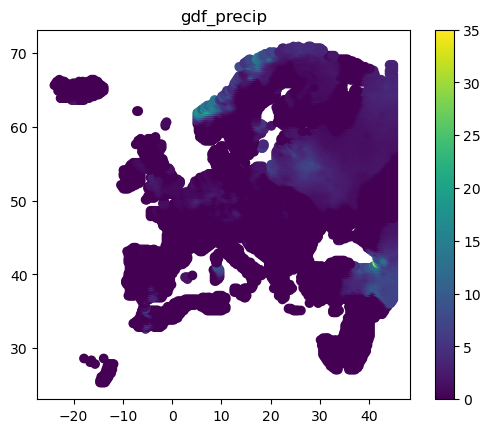

In [74]:
gdf_precip.plot(column="rr", legend=True)
plt.title("gdf_precip")

In [75]:
gdf_precip.rr.value_counts()

rr
0.000000     12602
1.500000       291
1.400000       287
1.700000       272
1.300000       263
             ...  
18.400000        1
17.300001        1
14.900001        1
17.800001        1
14.600000        1
Name: count, Length: 171, dtype: int64

## Merge with GDF_Grid_5km

<Axes: >

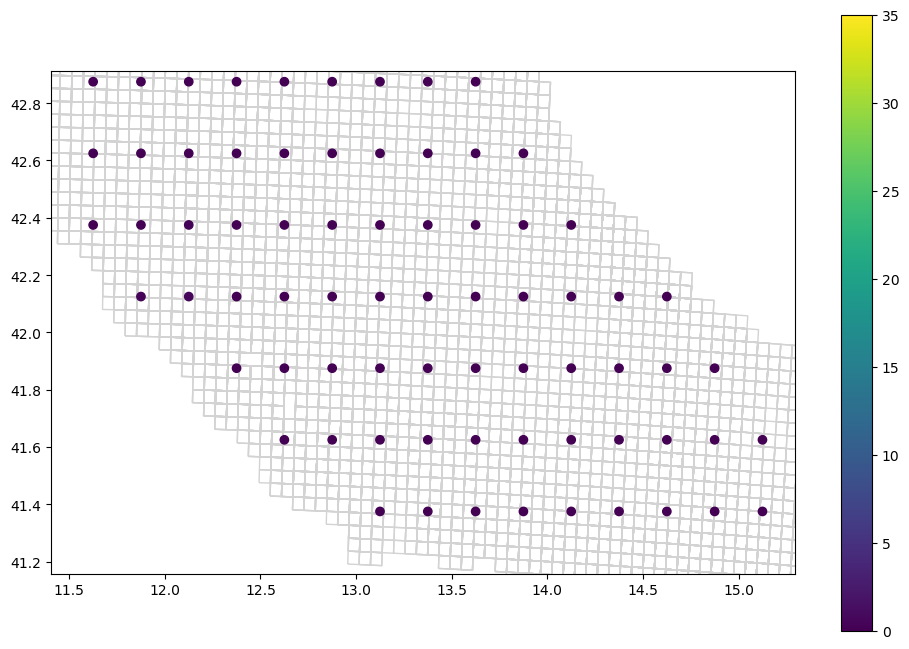

In [76]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_5km_uaa.plot(ax=ax, column="UAA", facecolor="none", edgecolor="lightgrey")
gdf_precip.plot(ax=ax, column="rr", legend=True)

<Axes: >

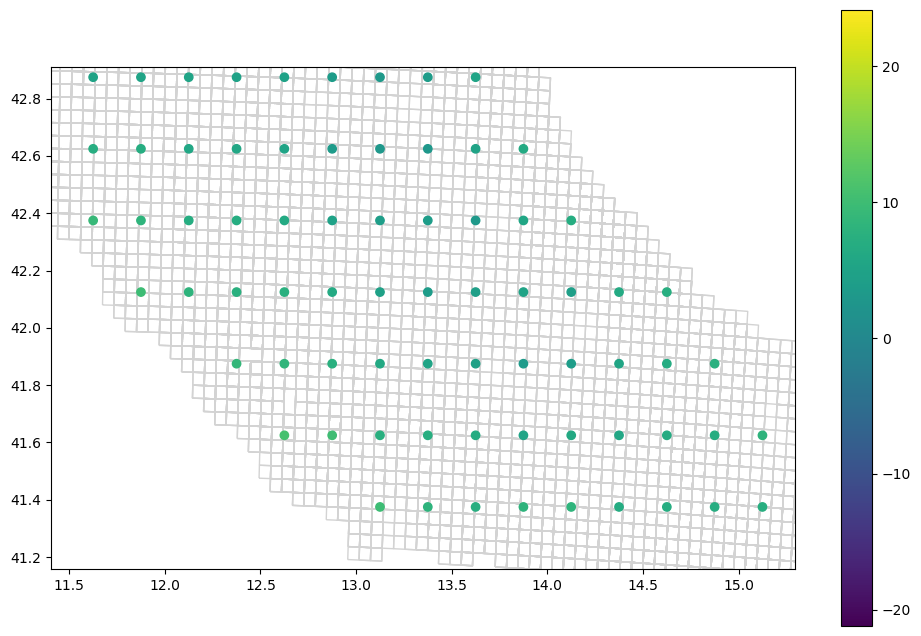

In [77]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_5km_uaa.plot(ax=ax, column="UAA", facecolor="none", edgecolor="lightgrey")
gdf_mean_temp.plot(ax=ax, column="tg", legend=True)

→気温．降水量の粒度低い！0.25degではなく0.1degでやろう

### Mean temperature & Precipitation(0.1)

In [78]:
convert_nc_to_gdf("data/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e.nc",
                  "data/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e.shp")

In [79]:
convert_nc_to_gdf("data/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e.nc",
                  "data/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e.shp")

In [80]:
gdf_mean_temp = gpd.read_file("data/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e.shp").set_crs("EPSG:4326")
gdf_precip = gpd.read_file("data/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e/rr_ens_mean_0.1deg_reg_2011-2024_v30.0e.shp").set_crs("EPSG:4326")

<Axes: >

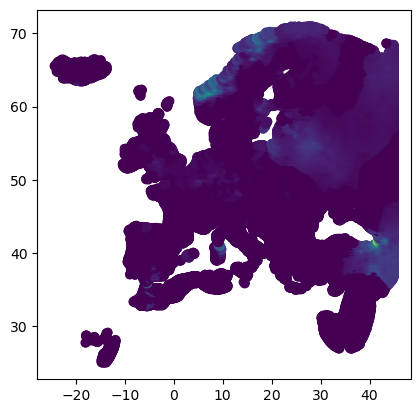

In [81]:
gdf_precip.plot(column="rr")

<Axes: >

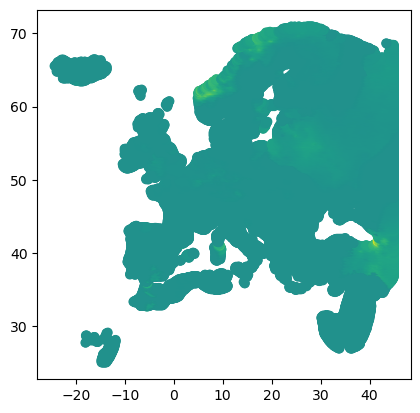

In [82]:
gdf_precip.plot(column="rr",norm=colors.CenteredNorm())

<Axes: >

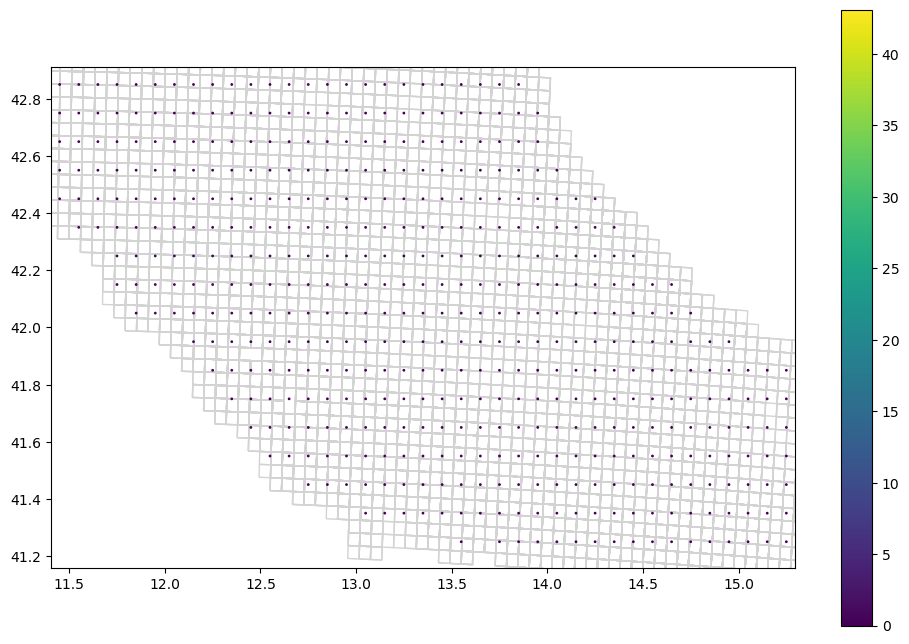

In [83]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_5km_uaa.plot(ax=ax, column="UAA", facecolor="none", edgecolor="lightgrey")
gdf_precip.plot(ax=ax, column="rr", legend=True, markersize=1)

<Axes: >

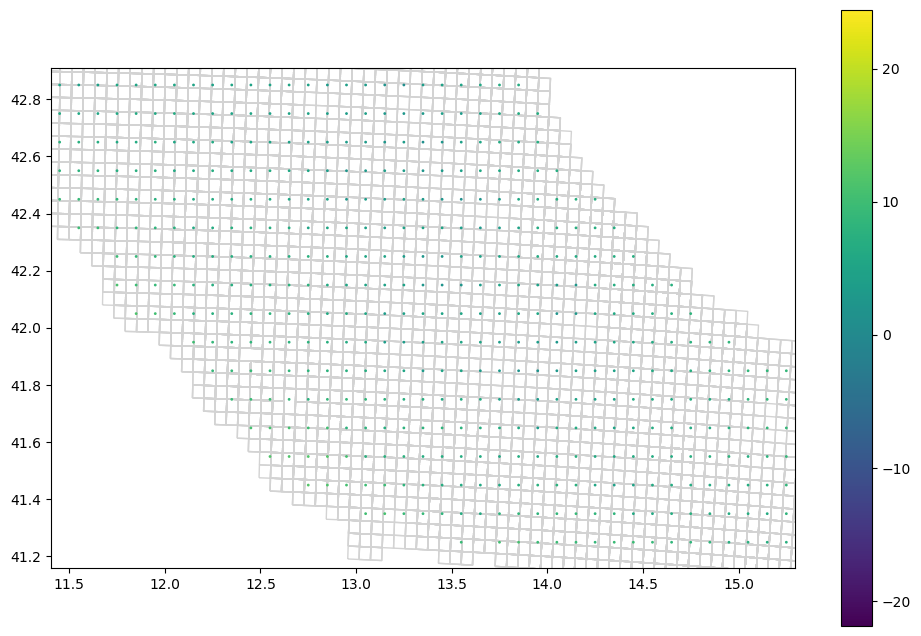

In [84]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_5km_uaa.plot(ax=ax, column="UAA", facecolor="none", edgecolor="lightgrey")
gdf_mean_temp.plot(ax=ax, column="tg", legend=True, markersize=1)

# 10km四方か20km四方の方がbetter?

In [85]:
# 人口密度メッシュ（10km四方）
gdf_grid_10km = gpd.read_file("data/grid/grid_10km_surf.gpkg")
gdf_grid_10km = gdf_grid_10km[gdf_grid_10km["CNTR_ID"] == "IT"].to_crs("EPSG:4326")

In [86]:
# 人口密度メッシュ（20km四方）
gdf_grid_20km = gpd.read_file("data/grid/grid_20km_surf.gpkg")
gdf_grid_20km = gdf_grid_20km[gdf_grid_20km["CNTR_ID"] == "IT"].to_crs("EPSG:4326")

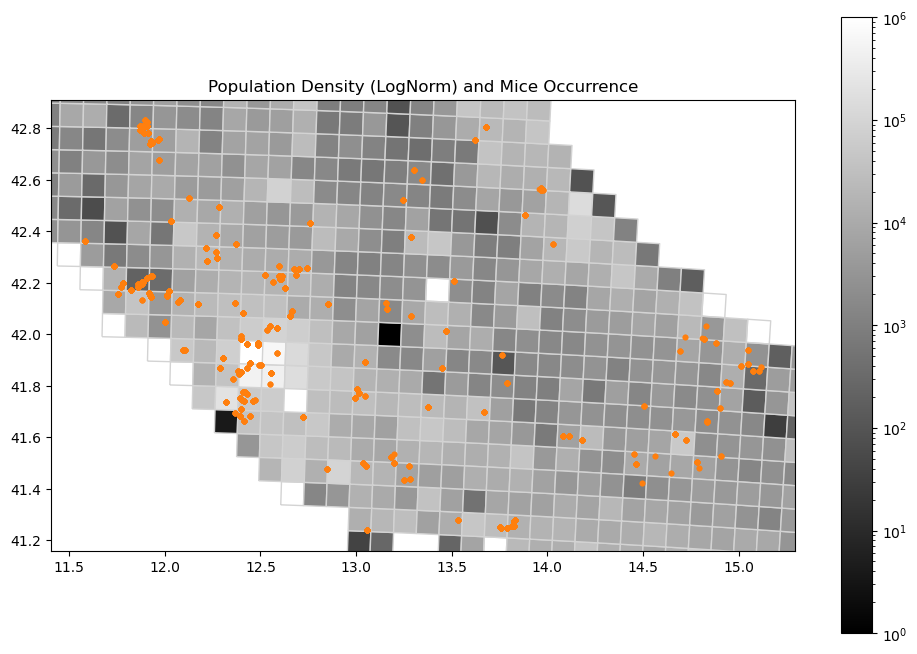

In [87]:
plot_gdfs(gdf_mice,gdf_grid_10km,True)

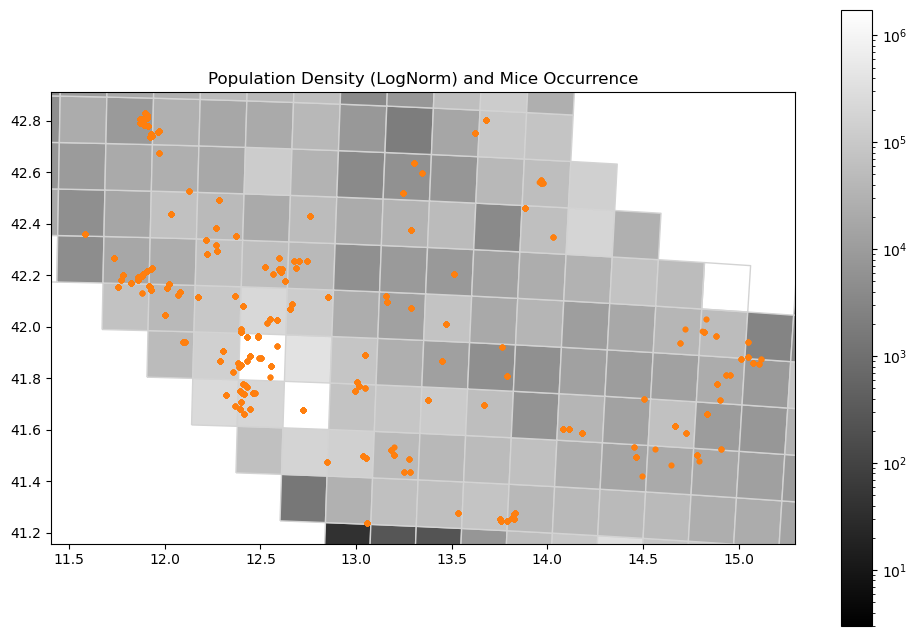

In [88]:
plot_gdfs(gdf_mice,gdf_grid_20km,True)

In [89]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_10km.plot(ax=ax, facecolor="none", edgecolor="lightgrey")
gdf_mean_temp.plot(ax=ax, column="tg", legend=True, markersize=1)

<Axes: >

<Axes: >

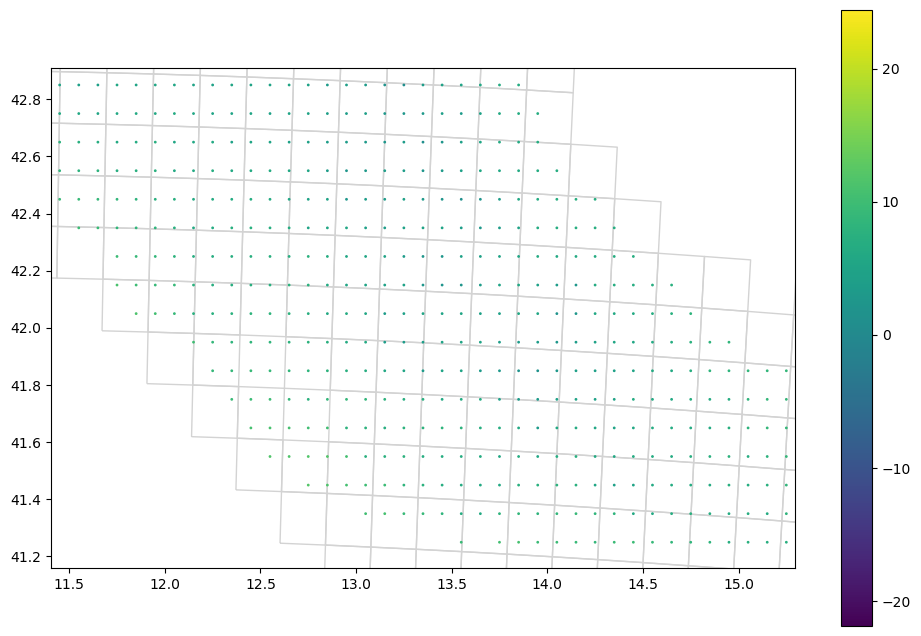

In [90]:
ax = gdf_mice.plot(markersize=0, figsize=(12,8))
plt.autoscale(False)
gdf_grid_20km.plot(ax=ax, facecolor="none", edgecolor="lightgrey")
gdf_mean_temp.plot(ax=ax, column="tg", legend=True, markersize=1)

## →10km四方で行く

## ここからの流れ
1. 10km四方で気温，降水量，ねずみoccurrence，人口密度を突っ込んだgdf作る
2. neural networkで予測モデル作る: outputは連続値　(train_data=gdf[gdf[ねずみoccurrence]!=0])
3. Cross validationなどでテスト
4. 最終的に，gdf[gdf[ねずみoccurrence]=0]にも連続値を当てはめてみて，ネズミの発生分布をつくる
5. レポートにする！

In [91]:
# Insert "mice_occurrence" (the number of mice observed in the grid) in gdf_grid_5km
gdf_grid_10km_merged = gdf_grid_10km.join(
    gpd.sjoin(gdf_mice.to_crs(gdf_grid_10km.crs), gdf_grid_10km).groupby("index_right").size().rename("mice_occurrence"),
    how="left",
)

In [92]:
gdf_grid_10km_merged["mice_occurrence"].value_counts()

mice_occurrence
12.0     8
18.0     6
9.0      5
5.0      5
11.0     4
2.0      4
10.0     4
7.0      4
4.0      4
16.0     3
14.0     3
8.0      3
27.0     3
13.0     2
24.0     2
43.0     2
17.0     2
81.0     2
53.0     2
20.0     2
23.0     2
34.0     2
52.0     1
38.0     1
61.0     1
77.0     1
48.0     1
6.0      1
19.0     1
26.0     1
121.0    1
32.0     1
36.0     1
74.0     1
22.0     1
25.0     1
15.0     1
28.0     1
46.0     1
Name: count, dtype: int64

In [93]:
gdf_grid_10km_uaa = gdf_grid_10km_merged.sjoin(gdf_agri_uaa.to_crs(gdf_grid_10km_merged.crs)[["geometry", "UAA"]], how="inner", predicate='intersects').to_crs("EPSG:4326")
gdf_grid_10km_uaa = gdf_grid_10km_uaa.drop(["index_right"],axis=1)

In [94]:
gdf_grid_10km_uaa_precip = gdf_grid_10km_uaa.sjoin(gdf_precip[["geometry", "rr"]], how="inner", predicate='intersects').to_crs("EPSG:4326")
gdf_grid_10km_uaa_precip = gdf_grid_10km_uaa_precip.drop(["index_right"],axis=1)

In [95]:
gdf_grid_10km_uaa_precip_temp_all = gdf_grid_10km_uaa_precip.sjoin(gdf_mean_temp[["geometry", "tg"]], how="inner", predicate='intersects').to_crs("EPSG:4326")
gdf_grid_10km_uaa_precip_temp_all = gdf_grid_10km_uaa_precip_temp_all.drop(["index_right"],axis=1)

In [96]:
gdf_grid_10km_uaa_precip_temp = gdf_grid_10km_uaa_precip_temp_all[["geometry","mice_occurrence","TOT_P_2021","UAA","rr","tg"]]

In [97]:
gdf_grid_10km_uaa_precip_temp[["rr","tg"]].value_counts()

rr   tg    
0.0   1.38     318
      7.80     231
      6.81     195
      8.55     190
      1.42     188
              ... 
3.1   8.36       3
0.0  -5.45       3
     -4.39       2
     -6.48       2
      11.98      1
Name: count, Length: 1561, dtype: int64

## Fill NaN

In [98]:
gdf_grid_10km_uaa_precip_temp["mice_occurrence"].value_counts()

mice_occurrence
38.0     224
8.0      145
7.0      126
34.0     116
12.0     112
2.0      103
11.0     100
4.0       93
14.0      92
5.0       75
23.0      64
27.0      56
16.0      55
18.0      51
9.0       49
10.0      43
53.0      41
13.0      38
17.0      30
20.0      29
43.0      25
77.0      24
28.0      18
52.0      16
25.0      15
46.0      15
74.0      14
19.0      13
61.0      13
36.0      10
24.0      10
121.0      9
32.0       9
81.0       9
Name: count, dtype: int64

In [99]:
len(gdf_grid_10km_uaa_precip_temp)

59901

In [100]:
gdf_grid_10km_uaa_precip_temp[["TOT_P_2021","mice_occurrence","rr","tg"]].isna().sum()

TOT_P_2021             0
mice_occurrence    58059
rr                     0
tg                     0
dtype: int64

→最高！

In [101]:
gdf_grid_10km_uaa_precip_temp[["TOT_P_2021","mice_occurrence","rr","tg"]].isna().sum()

TOT_P_2021             0
mice_occurrence    58059
rr                     0
tg                     0
dtype: int64

## Visualisation

Text(0.5, 1.0, 'Mice Occurrence')

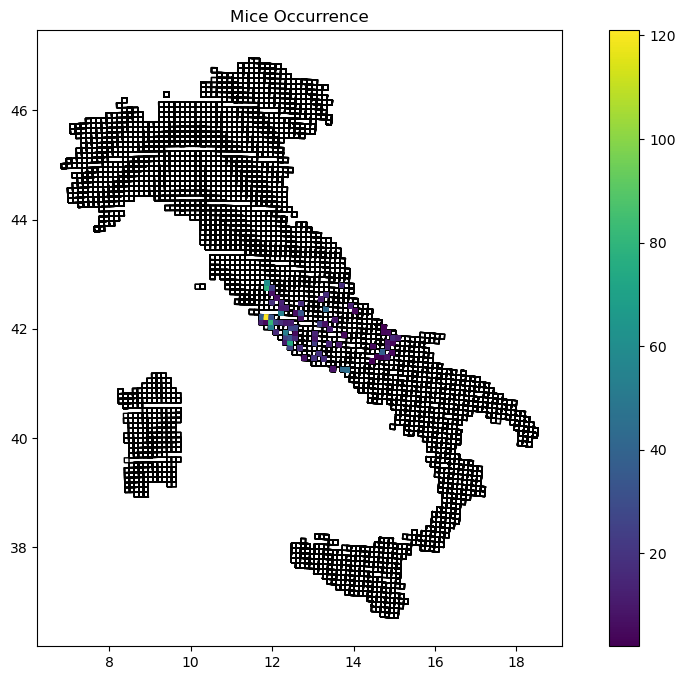

In [102]:
ax = gdf_grid_10km_uaa_precip_temp.plot(facecolor="none", figsize=(12,8))
gdf_grid_10km_uaa_precip_temp.plot(ax=ax, column="mice_occurrence", legend=True, figsize=(12,8))
plt.title("Mice Occurrence")

Text(0.5, 1.0, 'mean temperature')

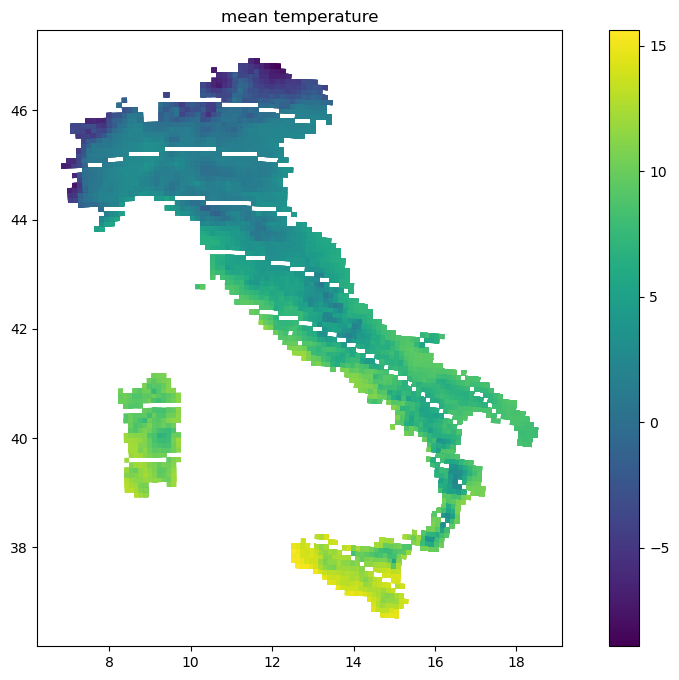

In [103]:
gdf_grid_10km_uaa_precip_temp.plot(column="tg", legend=True, figsize=(12,8))
plt.title("mean temperature")

Text(0.5, 1.0, 'precipitation')

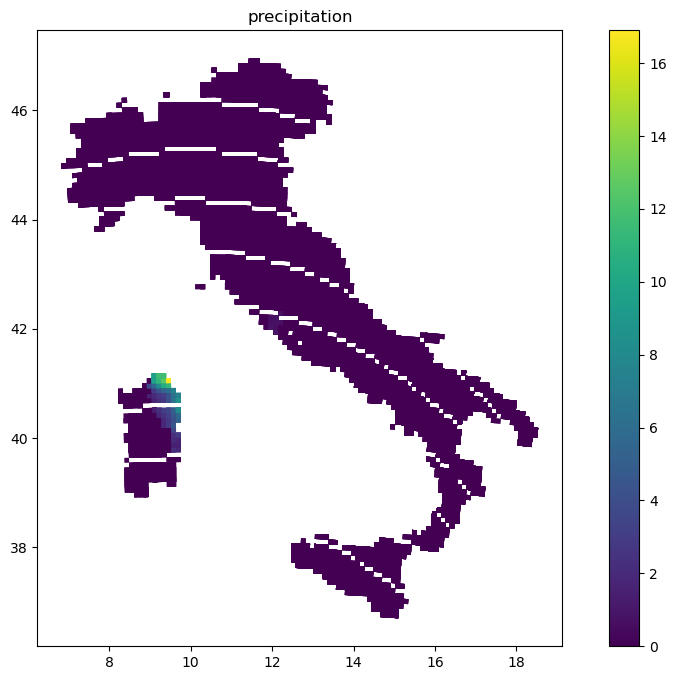

In [104]:
gdf_grid_10km_uaa_precip_temp.plot(column="rr", legend=True, figsize=(12,8))
plt.title("precipitation")

In [105]:
gdf_grid_10km_uaa_precip_temp.plot(column="rr", legend=True, figsize=(12,8), norm=colors.LogNorm())
plt.title("precipitation LogNorm")

Text(0.5, 1.0, 'precipitation LogNorm')

In [106]:
ax = gdf_grid_10km_uaa_precip_temp.plot(column="mice_occurrence", figsize=(12,8), facecolor="none")
plt.autoscale(False)
gdf_grid_10km_uaa_precip_temp.plot(ax=ax, column="mice_occurrence", legend=True)
plt.title("mice_occurrence")

Text(0.5, 1.0, 'mice_occurrence')

In [107]:
ax = gdf_grid_10km_uaa_precip_temp.plot(column="mice_occurrence", figsize=(12,8), facecolor="none")
plt.autoscale(False)
gdf_grid_10km_uaa_precip_temp.plot(ax=ax, column="tg", legend=True)
plt.title("mean temperature")

Text(0.5, 1.0, 'mean temperature')

→地球の表面の丸み（？）によって縞模様が出来てる？
縞模様は欠損値？

Text(0.5, 1.0, 'precipitation')

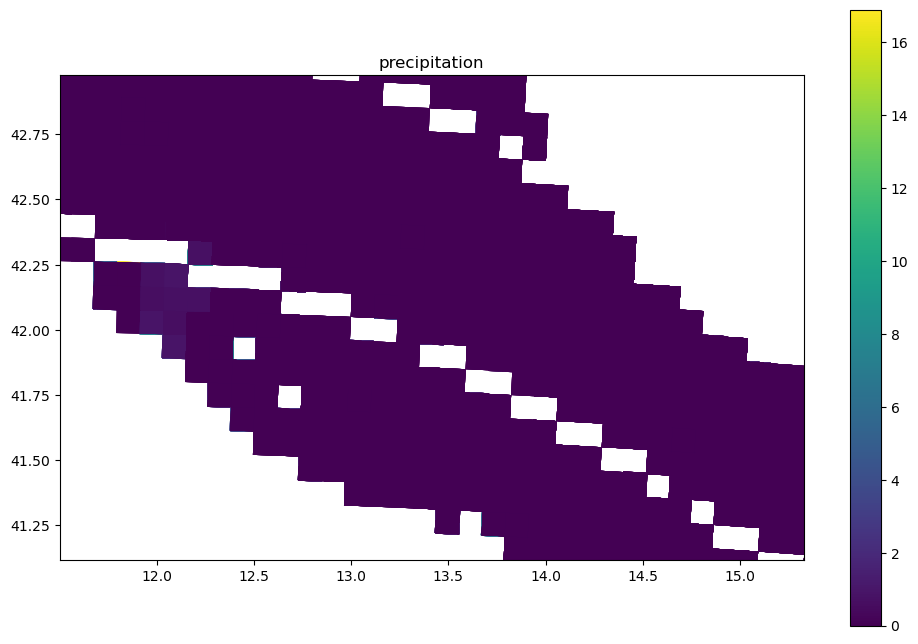

In [108]:
ax = gdf_grid_10km_uaa_precip_temp.plot(column="mice_occurrence", figsize=(12,8), facecolor="none")
plt.autoscale(False)
gdf_grid_10km_uaa_precip_temp.plot(ax=ax, column="rr", legend=True)
plt.title("precipitation")

Text(0.5, 1.0, 'precipitation (LogNorm)')

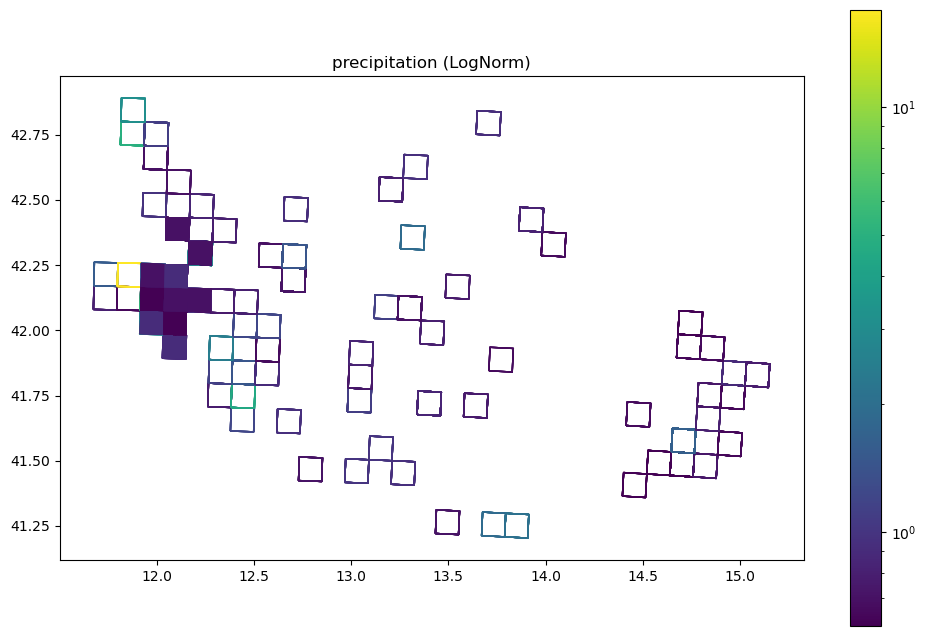

In [109]:
ax = gdf_grid_10km_uaa_precip_temp.plot(column="mice_occurrence", figsize=(12,8), facecolor="none")
plt.autoscale(False)
gdf_grid_10km_uaa_precip_temp.plot(ax=ax, column="rr", legend=True, norm=colors.LogNorm())
plt.title("precipitation (LogNorm)")

Text(0.5, 1.0, 'Total Population (2021)')

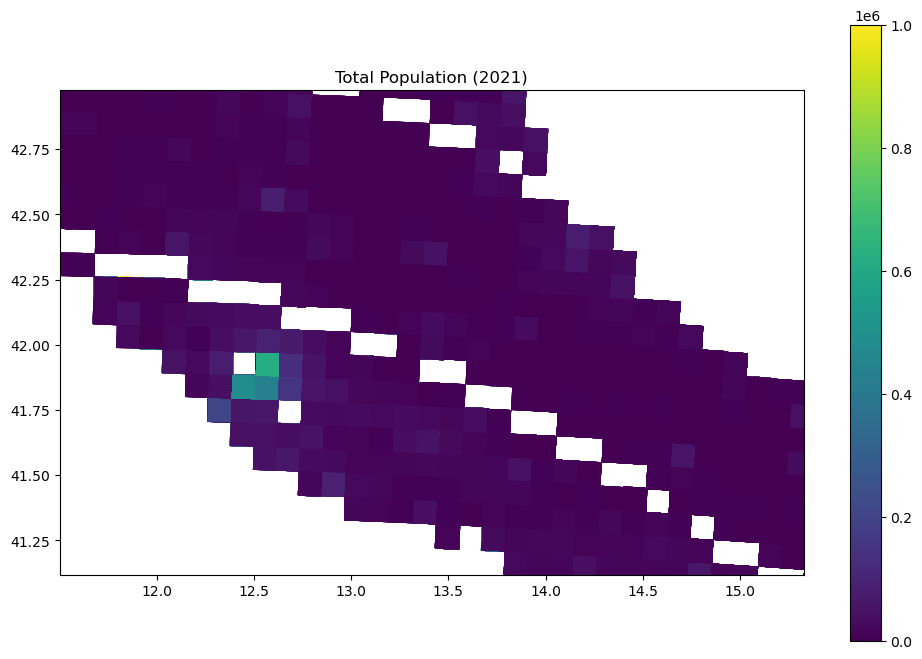

In [110]:
ax = gdf_grid_10km_uaa_precip_temp.plot(column="mice_occurrence", figsize=(12,8), facecolor="none")
plt.autoscale(False)
gdf_grid_10km_uaa_precip_temp.plot(ax=ax, column="TOT_P_2021", legend=True)
plt.title("Total Population (2021)")

In [111]:
gdf_grid_10km_uaa_precip_temp.head()

geometry  mice_occurrence  \
206  POLYGON ((12.49445 41.52059, 12.61373 41.51754...              NaN   
206  POLYGON ((12.49445 41.52059, 12.61373 41.51754...              NaN   
206  POLYGON ((12.49445 41.52059, 12.61373 41.51754...              NaN   
206  POLYGON ((12.49445 41.52059, 12.61373 41.51754...              NaN   
206  POLYGON ((12.49445 41.52059, 12.61373 41.51754...              NaN   

     TOT_P_2021     UAA   rr     tg  
206       43840   380.0  0.0  11.62  
206       43840  1800.0  0.0  11.62  
206       43840   560.0  0.0  11.62  
206       43840  1130.0  0.0  11.62  
206       43840   650.0  0.0  11.62

In [112]:
gdf_grid_10km_uaa_precip_temp.dtypes


geometry           geometry
mice_occurrence     float64
TOT_P_2021            int64
UAA                 float64
rr                  float64
tg                  float64
dtype: object

→geometry（id扱い）以外は全て数値データになった！ Ready to analyse

# Machine Learning
やっと解析に入れる！！！！歓喜

In [113]:
gdf_grid_10km_uaa_precip_temp

geometry  mice_occurrence  \
206    POLYGON ((12.49445 41.52059, 12.61373 41.51754...              NaN   
206    POLYGON ((12.49445 41.52059, 12.61373 41.51754...              NaN   
206    POLYGON ((12.49445 41.52059, 12.61373 41.51754...              NaN   
206    POLYGON ((12.49445 41.52059, 12.61373 41.51754...              NaN   
206    POLYGON ((12.49445 41.52059, 12.61373 41.51754...              NaN   
...                                                  ...              ...   
74754  POLYGON ((16.05728 41.27703, 16.17585 41.26973...              NaN   
74754  POLYGON ((16.05728 41.27703, 16.17585 41.26973...              NaN   
74754  POLYGON ((16.05728 41.27703, 16.17585 41.26973...              NaN   
74754  POLYGON ((16.05728 41.27703, 16.17585 41.26973...              NaN   
74754  POLYGON ((16.05728 41.27703, 16.17585 41.26973...              NaN   

       TOT_P_2021     UAA   rr     tg  
206         43840   380.0  0.0  11.62  
206         43840  1800.0  0.0  11.62  
206         43840   560.0  0.0  11.62  
206         43840  1130.0  0.0  11.62  
206         43840   650.0  0.0  11.62  
...           ...     ...  ...    ...  
74754       27530   720.0  0.0   9.28  
74754       27530  1020.0  0.0   9.28  
74754       27530   960.0  0.0   9.28  
74754       27530     NaN  0.0   9.28  
74754       27530   720.0  0.0   9.28  

[59901 rows x 6 columns]

In [114]:
# train dataを目的変数X，説明変数Yに分ける
train_X_geom = gdf_grid_10km_uaa_precip_temp[~gdf_grid_10km_uaa_precip_temp["mice_occurrence"].isnull()].drop("mice_occurrence",axis=1).reset_index(drop=True)
train_y_geom = gdf_grid_10km_uaa_precip_temp[~gdf_grid_10km_uaa_precip_temp["mice_occurrence"].isnull()]["mice_occurrence"].reset_index(drop=True)

In [115]:
# mice_occurrence = Nanのものをtest_Xへ
test_X_geom = gdf_grid_10km_uaa_precip_temp[gdf_grid_10km_uaa_precip_temp["mice_occurrence"].isnull()].drop("mice_occurrence",axis=1).reset_index(drop=True)

In [116]:
X_test_geom = test_X_geom[["geometry"]].reset_index(drop=True)
X_test = test_X_geom.drop("geometry",axis=1).reset_index(drop=True)

## LightGBM

### Hold-out

In [117]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [210]:
# train dataの内20%をtest dataへ
X_train_and_geom, X_valid_and_geom, y_train, y_valid = train_test_split(train_X_geom, train_y_geom, test_size=0.2, random_state=42)

In [211]:
X_train_geom = X_train_and_geom[["geometry"]].reset_index(drop=True)
X_train = X_train_and_geom.drop("geometry", axis=1).reset_index(drop=True)

In [212]:
X_valid_geom = X_valid_and_geom[["geometry"]].reset_index(drop=True)
X_valid = X_valid_and_geom.drop("geometry", axis=1).reset_index(drop=True)

In [213]:
len(X_train)

1473

In [214]:
len(X_valid)

369

In [215]:
categories = ["TOT_P_2021","UAA","rr","tg"]

In [216]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, free_raw_data=False, reference=lgb_train)

In [217]:
lgbm_params = {
    "early_stopping_rounds": 20,
    "seed": 42 # Don't Panic!
}

In [218]:
model_lgb = lgb.train(lgbm_params,
                      lgb_train,
                      valid_sets=lgb_eval,
                      num_boost_round=100)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 1473, number of used features: 3
[LightGBM] [Info] Start training from score 20.844535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [219]:
model_lgb.feature_importance()

array([270,   1,   0, 155], dtype=int32)

<Axes: >

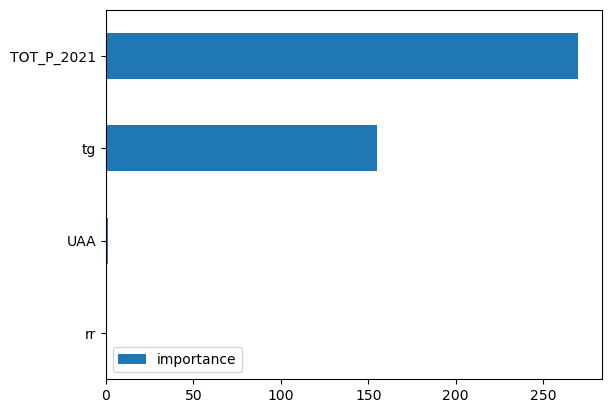

In [220]:
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance",ascending=True)
importance.plot.barh()

- そもそも全然雨が降ってないから降水量が効かない
- Populationが効いているのは，そもそも人口が多いところの方がネズミが報告されやすいというデータの特性もありそう

In [221]:
y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

In [222]:
df_y_pred = pd.DataFrame(y_pred, columns=["pred_mice_occurrence"])

In [223]:
df_y_pred_geom = pd.concat([df_y_pred, X_valid_geom], axis=1)

In [224]:
gdf_y_pred_geom = gpd.GeoDataFrame(df_y_pred_geom)

In [225]:
gdf_y_pred_geom = gdf_y_pred_geom.set_crs("EPSG:4326")

In [226]:
gdf_y_pred_geom

pred_mice_occurrence                                           geometry
0               12.725705  POLYGON ((13.14151 42.49687, 13.26268 42.49304...
1                8.408746  POLYGON ((12.64085 42.14970, 12.76135 42.14647...
2               38.087414  POLYGON ((14.64615 41.53406, 14.76533 41.52844...
3               20.427605  POLYGON ((13.11814 42.04564, 13.23841 42.04184...
4               11.580153  POLYGON ((12.16520 42.34179, 12.28610 42.33912...
..                    ...                                                ...
364             34.019238  POLYGON ((12.03517 42.07340, 12.15554 42.07089...
365              8.431218  POLYGON ((13.48408 42.12404, 13.60449 42.11979...
366              7.361994  POLYGON ((12.52410 42.24308, 12.64479 42.23998...
367             41.997902  POLYGON ((13.78924 41.20832, 13.90785 41.20372...
368             25.868808  POLYGON ((12.26583 41.79729, 12.38565 41.79451...

[369 rows x 2 columns]

In [227]:
gdf_grid_10km_uaa_precip_temp[gdf_grid_10km_uaa_precip_temp["mice_occurrence"]>0]

geometry  mice_occurrence  \
211    POLYGON ((13.09072 41.50390, 13.20993 41.50014...             20.0   
211    POLYGON ((13.09072 41.50390, 13.20993 41.50014...             20.0   
211    POLYGON ((13.09072 41.50390, 13.20993 41.50014...             20.0   
211    POLYGON ((13.09072 41.50390, 13.20993 41.50014...             20.0   
211    POLYGON ((13.09072 41.50390, 13.20993 41.50014...             20.0   
...                                                  ...              ...   
74737  POLYGON ((14.39489 41.36442, 14.51376 41.35910...              2.0   
74737  POLYGON ((14.39489 41.36442, 14.51376 41.35910...              2.0   
74737  POLYGON ((14.39489 41.36442, 14.51376 41.35910...              2.0   
74737  POLYGON ((14.39489 41.36442, 14.51376 41.35910...              2.0   
74737  POLYGON ((14.39489 41.36442, 14.51376 41.35910...              2.0   

       TOT_P_2021     UAA   rr    tg  
211          8420  1840.0  0.0  7.50  
211          8420  1020.0  0.0  7.50  
211          8420   420.0  0.0  7.50  
211          8420  1440.0  0.0  7.50  
211          8420   670.0  0.0  7.50  
...           ...     ...  ...   ...  
74737         864   350.0  0.0  4.99  
74737         864  3550.0  0.0  4.99  
74737         864   290.0  0.0  4.99  
74737         864  5640.0  0.0  4.99  
74737         864  3080.0  0.0  4.99  

[1842 rows x 6 columns]

Text(0.5, 1.0, 'pre-trained mice_occurrence')

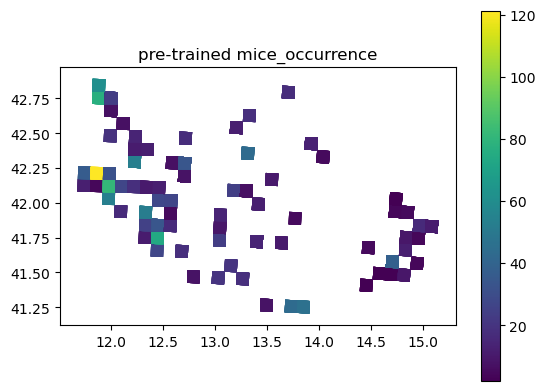

In [228]:
gdf_grid_10km_uaa_precip_temp.plot(column="mice_occurrence", legend=True)
plt.title("pre-trained mice_occurrence")

Text(0.5, 1.0, 'predicted mice_occurrence')

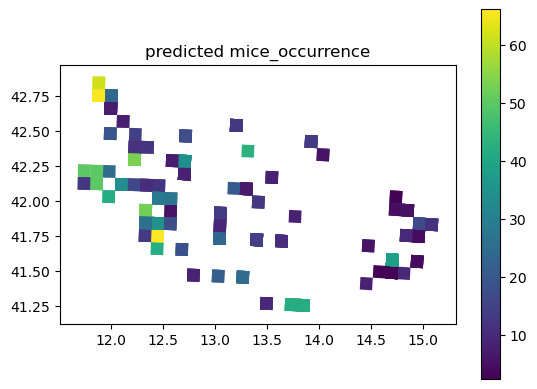

In [229]:
gdf_y_pred_geom.plot(column="pred_mice_occurrence", legend=True)
plt.title("predicted mice_occurrence")

In [230]:
y_pred_whole_italy = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
df_y_pred_whole_italy = pd.DataFrame(y_pred_whole_italy, columns=["pred_mice_occurrence"])
df_y_pred_whole_italy_geom = pd.concat([df_y_pred_whole_italy, X_test_geom], axis=1)
gdf_y_pred_whole_italy_geom = gpd.GeoDataFrame(df_y_pred_whole_italy_geom)
gdf_y_pred_whole_italy_geom = gdf_y_pred_whole_italy_geom.set_crs("EPSG:4326")

Text(0.5, 1.0, 'predicted mice_occurrence in whole italy')

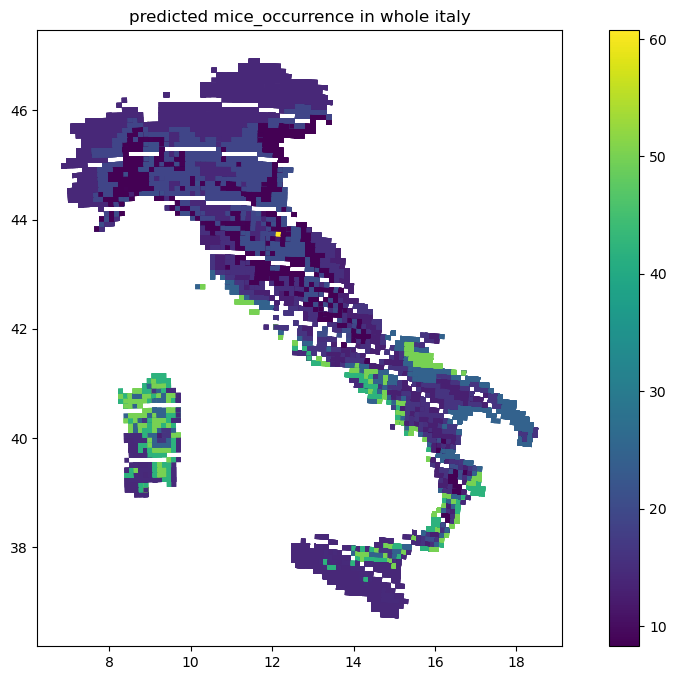

In [231]:
gdf_y_pred_whole_italy_geom.plot(column="pred_mice_occurrence", legend=True, figsize=(12,8))
plt.title("predicted mice_occurrence in whole italy")

Text(0.5, 1.0, 'predicted+real mice_occurrence in whole italy')

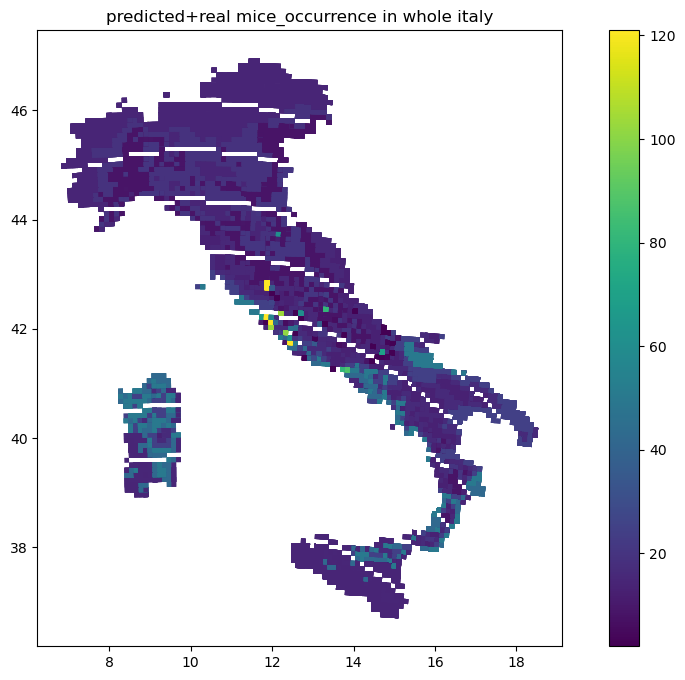

In [232]:
ax = gdf_y_pred_whole_italy_geom.plot(column="pred_mice_occurrence", legend=True, figsize=(12,8), vmin=gdf_grid_10km_uaa_precip_temp["mice_occurrence"].min(), vmax=gdf_grid_10km_uaa_precip_temp["mice_occurrence"].max())
gdf_grid_10km_uaa_precip_temp.plot(ax=ax, column="mice_occurrence", vmin=gdf_y_pred_whole_italy_geom["pred_mice_occurrence"].min(), vmax=gdf_y_pred_whole_italy_geom["pred_mice_occurrence"].max())
plt.title("predicted+real mice_occurrence in whole italy")

In [233]:
gdf_y_pred_whole_italy_geom.plot(column="pred_mice_occurrence", legend=True, figsize=(12,8), vmin=gdf_grid_10km_uaa_precip_temp["mice_occurrence"].min(), vmax=gdf_grid_10km_uaa_precip_temp["mice_occurrence"].max())
plt.title("predicted mice_occurrence in whole italy")

Text(0.5, 1.0, 'predicted mice_occurrence in whole italy')

In [234]:
ax = gdf_y_pred_whole_italy_geom.plot(column="pred_mice_occurrence", legend=True, figsize=(12,8), vmin=gdf_grid_10km_uaa_precip_temp["mice_occurrence"].min(), vmax=gdf_grid_10km_uaa_precip_temp["mice_occurrence"].max())
gdf_grid_10km_uaa_precip_temp.plot(ax=ax, column="mice_occurrence", vmin=gdf_grid_10km_uaa_precip_temp["mice_occurrence"].min(), vmax=gdf_grid_10km_uaa_precip_temp["mice_occurrence"].max())
plt.title("predicted+real mice_occurrence in whole italy")

Text(0.5, 1.0, 'predicted+real mice_occurrence in whole italy')

### Hold-out Analyse Accuracy

In [235]:
from sklearn.metrics import accuracy_score

In [236]:
accuracy_score(y_valid, np.round(y_pred))

0.4281842818428184

とりあえず結果と言える結果になった！
## TODO
- 縞模様になっている欠損gridの原因を突き止める: 規則的になっているので，気象データを読み込む時にこうなった可能性がある．
- とりあえずLightGBM以外を試すには時間が無いから，cross validationで精度が上がるかだけ見てみる？
  - →もち，他の分析手法を試すのもあり
- 論文の形にする